## Miquel Monge Dalmau
---

# Metric Learning

In this practical, we will calculate 2-dimensional embeddings (so that we can easily visualise them) using different approaches: a classification network, a siamese network, and a triplet network. We will use FashionMNIST.

First some preliminary stuff. Apart from typical imports, we define also two functions that will help us later on to generate embeddings for all our data and to plot them in a 2D scatter plot.

> NOTES CLASSE:


> FMNIST imatges de la mateixa categoria son molt similars. La aplicacio real d'aixo es un dataset divers on les imatges no siguin facilment diferenciables. Donada una query, no queda clar si la clase 'x1' o la 'x2' és la que fa match.

In [ ]:
import os
import random

import torch
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)

# Donat el model pre-entrenat, ens projecta la projecció de l'espai
# fa forward passes del dataloader tornant els embeddings del dataset.
def extract_embeddings(dataloader, model, aux=2):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), aux))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels


## Import data

Import the FashionMNIST data and define datasets and data loaders.

In [ ]:
mean, std = 0.28604059698879553, 0.35302424451492237

train_dataset = FashionMNIST('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

In [ ]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 2, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## The Embedding Network

To do the embedding always in the same manner, we will define the embedding part once, and then reuse it with different networks. The embedding we will use is a small CNN architecture, followed by a couple of FC layers that bring down the output to 2 dimensions (so that we can plot the results later).

> Donada una imatge ens la projecta/incrustar a l'espai (embedding). 
Constructor predefinit, unes capes max pooling. La ultima capa es la que definirà el espai. Fem 2 dimensions el embedding per facilitar la projecció (eixos x i y). La sortida del model serà dos valors numèrics, sense activació, perquè ens pot interessar tenir cordenades positives i negatives.

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__() 
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

## Classification Head

The first embedding we will learn is by using a classification head. We define our classification model to use our standard embedding to 2 dimensions, then bring it up to the number of classes (10 in the case if FashionMNIST) and return the logits. We then train it using `torch.nn.CrossEntropyLoss()`.

> Creem model que accepta com a paràmetre un embedding (el del model d'adalt). Al final necesitarem passar de la sortida del embedding (2-dim) al nombre de classes.

> PReLU és una variació de la ReLU(). Després veurem si el model del embedding te sentit. Els models embedding i classification s'entrenen junts. De moment utilitzem un loss de classificació. El coll d'apolla es posar tot a dos dimensions.

In [ ]:
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        return self.fc1(output)

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [ ]:
def train_epoch(train_loader, model, loss_fn, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        data = data.to(device)

        optimizer.zero_grad()

        outputs = model(data)

        loss = loss_fn(outputs, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Evaluate on training set
        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= (batch_idx + 1)
    accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, accuracy

@torch.no_grad()
def test_epoch(val_loader, model, loss_fn):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        target = target.to(device)
        data = data.to(device)

        outputs = model(data)

        loss = loss_fn(outputs, target)
        val_loss += loss.item()

        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [ ]:
embedding_net = EmbeddingNet().to(device)
n_classes = 10
model = ClassificationNet(embedding_net, n_classes=n_classes)
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss() # estem entrenant un classificador, encara no fem metric learning
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

In [ ]:
for epoch in range(n_epochs):
    
    # Train stage
    train_loss, acc = train_epoch(train_loader, model, loss_fn, optimizer)

    scheduler.step()
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, train_loss, acc)

    # Validation stage
    val_loss, acc = test_epoch(test_loader, model, loss_fn)
    val_loss /= len(test_loader)

    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, val_loss, acc)

    print(message)

Epoch: 1/10. Train set: Average loss: 1.3059 Accuracy: 49.69
Epoch: 1/10. Validation set: Average loss: 0.9668 Accuracy: 58.75
Epoch: 2/10. Train set: Average loss: 0.6582 Accuracy: 78.16
Epoch: 2/10. Validation set: Average loss: 0.5775 Accuracy: 80.63
Epoch: 3/10. Train set: Average loss: 0.4980 Accuracy: 82.88
Epoch: 3/10. Validation set: Average loss: 0.5178 Accuracy: 83.93
Epoch: 4/10. Train set: Average loss: 0.4337 Accuracy: 85.55
Epoch: 4/10. Validation set: Average loss: 0.4776 Accuracy: 84.97
Epoch: 5/10. Train set: Average loss: 0.3801 Accuracy: 87.62
Epoch: 5/10. Validation set: Average loss: 0.4519 Accuracy: 86.83
Epoch: 6/10. Train set: Average loss: 0.3370 Accuracy: 89.14
Epoch: 6/10. Validation set: Average loss: 0.4229 Accuracy: 87.66
Epoch: 7/10. Train set: Average loss: 0.3091 Accuracy: 89.85
Epoch: 7/10. Validation set: Average loss: 0.4713 Accuracy: 86.85
Epoch: 8/10. Train set: Average loss: 0.2840 Accuracy: 90.70
Epoch: 8/10. Validation set: Average loss: 0.4115 

> Cada color representarà una classe de FMNIST. Aquest és el millor embedding que pot trobar la xarxa per després classificar la xarxa. A la xarxa li es igual si hi ha simulitud entre bambes i botes, el que importa es que hi hagi màxima separació entre classes diferents. Veiem que al mig estàn bastantes juntes, al model li està costant una mica separar entre classes.

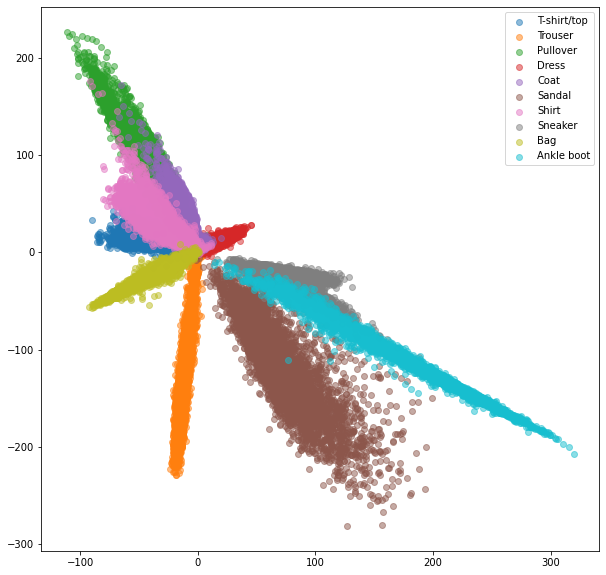

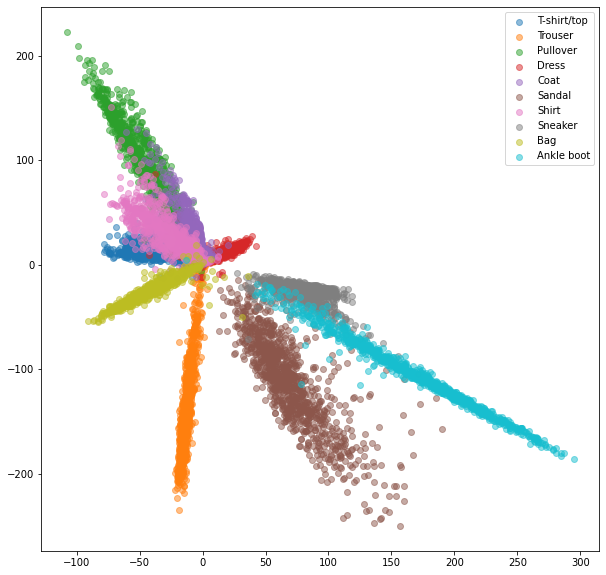

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Siamese Head

We will repeat the process with a siamese network, but in order to do that we need first to create a different dataset, that creates positive and negative pairs from the original dataset. The pairs will be generated on the fly, randomly, while training. While testing, we will maintain the same pairs always so that comparisons would make sense.

Note that here we just aim to create valid pairs, we do not do any mining (we do not care if they are easy, semi-hard or hard).

> Aqui ja entrenem model de metric learning. Les dues xarxes comparteixen pesos. Ara pasem dues imatges una per cada branca i mirem la distància entre embeddings. 


> Si hem passat imatges de samarretes, intentare que la distància entre embedding de un i l'altre sigui el més semblant possible (més petita possible).


> Si passem imatges de classes diferents hem de fer que la distància sigui la més gran posible.

In [ ]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        self.labels = self.mnist_dataset.targets
        self.data = self.mnist_dataset.data
        self.labels_set = set(self.labels.numpy())
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set} # quines imatges del dataset son de la mateixa label

        # si no estem en training tenim un test set pre-fixat, de manera que en diferents
        # iteracions tindrem la mateixa accuracy.    
        if not self.train:
            # generate fixed pairs for testing once at initialisation
            random_state = np.random.RandomState(29) # Fix random seed for testing

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.labels[i].item()]),
                               1]
                              for i in range(0, len(self.data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        # En el training generem les parelles de forma aleatòria,
        # en cada epoch millorem perquè generem noves parelles que no ha vist mai.
        if self.train:
            # Generate a positive or negative pair on the fly
            target = np.random.randint(0, 2) # randomly select positive or negative
            img1, label1 = self.data[index], self.labels[index].item()
            if target == 1: # Generate a POSITIVE pair
                siamese_index = index
                while siamese_index == index: # Make sure we do not use ourself as the positive pair
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else: # Generate a NEGATIVE pair
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.data[siamese_index]
        else:
            # Just retrieve the pair from the saved test pairs we generated at init
            img1 = self.data[self.test_pairs[index][0]]
            img2 = self.data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        # Get a PIL image to pass through thransform
        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        # im1, im2 i indicador que diu si es de la mateixa label o no
        return img1, img2, target 

        
    def __len__(self):
        return len(self.mnist_dataset)

Now we are ready to define our siamese net which just takes in one training sample (which now comprises a pair of images) and embeds them using our embedding function. It returns the two embeddings.

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        # Esperem rebre dues imatges
        # passaré les dues per el embedding 
        # retornaré la sortida del embedding per cada una
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

> El loss més simple per el metric learning. La funció de cost és converteix en una distància, es semblant a un loss de regressió.

> I.e: si son diferents vull que es separin, quan? Definiré un marge al voltant de una d'elles. Per exemple defineixo marge en img1, i vull que la img2 estigui fora d'aquest. Si punt fora de marge, no hi ha loss. La xarxa ho ha fet bé, hem conseguit apartar la img del marge, es igual on la enviem. 

The next thing to do is to define our loss function for the case of the siamese. In this case, we need a function that takes as input TWO vectors and one target that indicates if they are supposed to be a positive pair, or a negative pair, and implements the function:

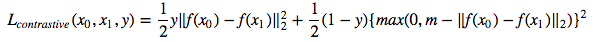

> Ara el farem servir com a criterion

In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        # losses = 0.5 * (target.float() * distances + (1 - target).float() * max(0, self.margin - (distances + self.eps).sqrt()).pow(2)) equivalent to
        # Ara utilitzem relu en lloc de max, si es negatiu la Relu retorna zero, si es positiu retorna el mateix valor. 
        losses = 0.5 * (target.float() * distances + (1 - target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        # totes funció cost ho tenen, permeten fer la mitjana o suma de tots els exemples del batch 
        # diferents formes de fer agregats del batch (suma/mitjana)
        return losses.mean() if size_average else losses.sum() 

We will also redefine the training and validation loops, as now the data loader gives us 2 samples and the loss function expects 2 samples.

In [ ]:
def train_epoch_siamese(train_loader, model, loss_fn, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    # el dataloader retorna dues imatges i el target (ens diu si son de la mateixa classe)
    for batch_idx, (data1, data2, target) in enumerate(train_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        optimizer.zero_grad()

        # les passem per la siamesa i retorna embeddings
        output1, output2 = model(data1, data2)

        # The loss is the only thing we can report here
        loss = loss_fn(output1, output2, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    total_loss /= (batch_idx + 1)
    return total_loss

@torch.no_grad()
def test_epoch_siamese(val_loader, model, loss_fn):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(val_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        output1, output2 = model(data1, data2)

        loss = loss_fn(output1, output2, target)
        val_loss += loss.item()
        
    return val_loss

In [ ]:
siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(test_dataset)

batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

margin = 1. # el marge es hiperparametre, l'escollim nosaltres
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.to(device)
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

In [ ]:
for epoch in range(n_epochs):

        # Train stage
        train_loss = train_epoch_siamese(siamese_train_loader, model, loss_fn, optimizer)
        scheduler.step()

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)

        # Validation stage
        val_loss = test_epoch_siamese(siamese_test_loader, model, loss_fn)
        val_loss /= len(siamese_test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, val_loss)

        print(message)

Epoch: 1/10. Train set: Average loss: 0.0488
Epoch: 1/10. Validation set: Average loss: 0.0401
Epoch: 2/10. Train set: Average loss: 0.0380
Epoch: 2/10. Validation set: Average loss: 0.0362
Epoch: 3/10. Train set: Average loss: 0.0339
Epoch: 3/10. Validation set: Average loss: 0.0335
Epoch: 4/10. Train set: Average loss: 0.0309
Epoch: 4/10. Validation set: Average loss: 0.0313
Epoch: 5/10. Train set: Average loss: 0.0293
Epoch: 5/10. Validation set: Average loss: 0.0305
Epoch: 6/10. Train set: Average loss: 0.0268
Epoch: 6/10. Validation set: Average loss: 0.0330
Epoch: 7/10. Train set: Average loss: 0.0254
Epoch: 7/10. Validation set: Average loss: 0.0293
Epoch: 8/10. Train set: Average loss: 0.0250
Epoch: 8/10. Validation set: Average loss: 0.0293
Epoch: 9/10. Train set: Average loss: 0.0216
Epoch: 9/10. Validation set: Average loss: 0.0267
Epoch: 10/10. Train set: Average loss: 0.0206
Epoch: 10/10. Validation set: Average loss: 0.0268


> Veiem que hauría de mantenir similurud entre classes. I.e: les samarretes estàn a prop dels pullovers (te sentit). Per l'altre costat, s'assemblen a abric i vestit. Molt separades tenim les sandalies i les botes. Les bosses separades no s'assemblen a res.

> **NOTA**: Veiem que l'embedding ha guanyat una mica de coherencia.

> Com estem triant parelles aleatoreis a vegades el loss tornarà zero. Serà millor parelles que estiguin molt aprop entre elles pero de diferent classe. Ara veurem tècniques per triar aquestes parelles o tripletes.

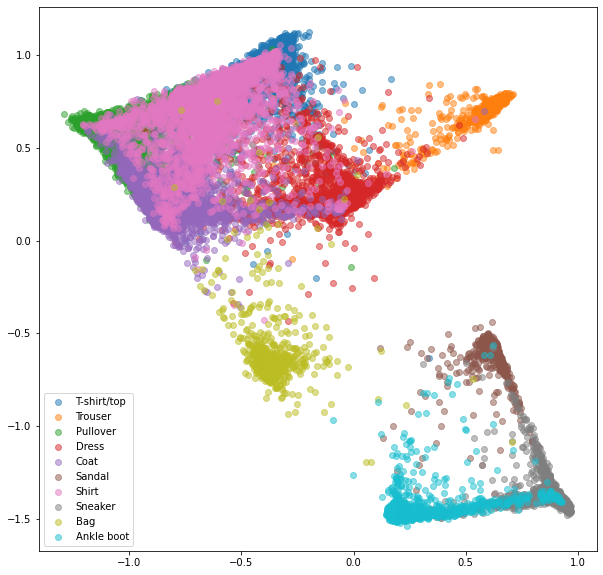

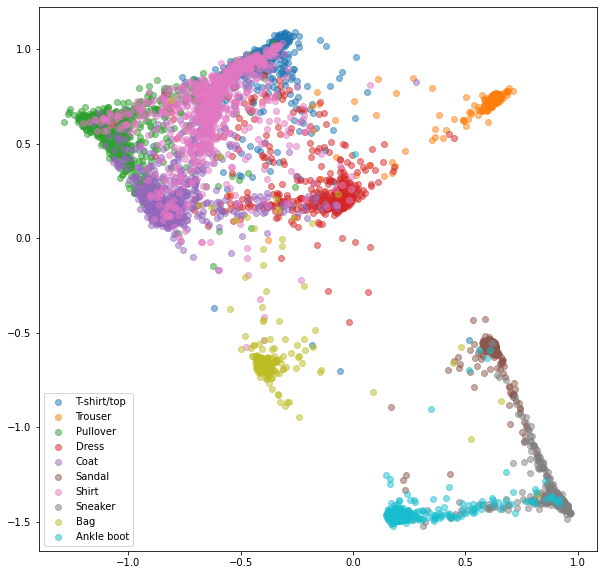

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

There are couple of problems with siamese and (triplet) networks the way we have implemented them up to this point.

- The number of possible pairs/triplets grows quadratically/cubically with the number of examples. It's infeasible to process them all
- We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with hard examples.
- Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch.

> Solucionarem els dos problemes que s'expliquen en els dos últims punts d'adalt. Però utilitzarem  una llibreria, no ho implementarem.

## Triplet Loss

We will now train FashionMNIST using a semi-hard Triplet Mining strategy, and visualize the embeddings. 

We will not implement any miner, loss or distance function by hand. Instead we will use [The Pytorch Metric Learning Library](https://github.com/KevinMusgrave/pytorch-metric-learning) (installed in the cell below) which implements everything we need.

Check its [docs](https://kevinmusgrave.github.io/pytorch-metric-learning/) so that you get an idea of how to use it.

In [ ]:
!pip install pytorch-metric-learning faiss-gpu

     |████████████████████████████████| 109 kB 5.3 MB/s 
     |████████████████████████████████| 85.5 MB 94 kB/s 


In [ ]:
from pytorch_metric_learning import losses, miners, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

We will redefine our training and test loops to use this library. The idea is that first we embedd all the data inside our batch. Then we will ask a *Miner* to find good triplets. The list of triplets (a list of tuples with indices) will be passed on to the loss function, that will calculate the loss based on them.

> Ara treballarem amb una sola xarxa, passem totes les imatges del batch per el embedding.

> Després li demanem a la llibrería que busqui les parelles o les tripletes. La funciño de cost nomñes utilitzarà les parelles que hem triat.

In [ ]:
def train(model, loss_func, mining_func, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)     # troba les millors parelles
        loss = loss_func(embeddings, labels, indices_tuple) # te en compte només les parelles triades
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

    return total_loss / (batch_idx + 1)

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(dataloader_num_workers=2)
    return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)

    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


We now need to define our miner. Here we will use a `TripletMarginMiner` and cosine similarity to measure the distance between embeddings. We will also use an "accuracy" calculator. The actual metric we will be using is a *precision at 1*, which is just a fancy way to ask whether the 1st nearest neighbour of each sample is of the same class.

https://kevinmusgrave.github.io/pytorch-metric-learning/accuracy_calculation/

In [ ]:
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="all") # molt important
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

Define the datasets, dataloaders, and the model to use. The model we will use here is just the embedding net on its own.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1., distance = distance)

Epoch 1 Iteration 0: Loss = 1.5038282871246338, Number of mined triplets = 100918
Epoch 1 Iteration 20: Loss = 1.0187771320343018, Number of mined triplets = 78609
Epoch 1 Iteration 40: Loss = 0.9631874561309814, Number of mined triplets = 65207
Epoch 1 Iteration 60: Loss = 0.9878606796264648, Number of mined triplets = 63433
Epoch 1 Iteration 80: Loss = 0.9777417778968811, Number of mined triplets = 59192
Epoch 1 Iteration 100: Loss = 0.9562528133392334, Number of mined triplets = 52102
Epoch 1 Iteration 120: Loss = 0.9602210521697998, Number of mined triplets = 64985
Epoch 1 Iteration 140: Loss = 0.9746075868606567, Number of mined triplets = 50341
Epoch 1 Iteration 160: Loss = 1.0039849281311035, Number of mined triplets = 45924
Epoch 1 Iteration 180: Loss = 1.0059207677841187, Number of mined triplets = 37053
Epoch 1 Iteration 200: Loss = 1.04155695438385, Number of mined triplets = 33409
Epoch 1 Iteration 220: Loss = 1.0071662664413452, Number of mined triplets = 34120
Epoch 1 Ite

100%|██████████| 313/313 [00:02<00:00, 133.23it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6231
Epoch 2 Iteration 0: Loss = 1.0228638648986816, Number of mined triplets = 36459
Epoch 2 Iteration 20: Loss = 0.9942553043365479, Number of mined triplets = 27476
Epoch 2 Iteration 40: Loss = 1.0166120529174805, Number of mined triplets = 41107
Epoch 2 Iteration 60: Loss = 0.9839572906494141, Number of mined triplets = 38131
Epoch 2 Iteration 80: Loss = 0.9980123043060303, Number of mined triplets = 35202
Epoch 2 Iteration 100: Loss = 1.001841425895691, Number of mined triplets = 38797
Epoch 2 Iteration 120: Loss = 1.00986647605896, Number of mined triplets = 38007
Epoch 2 Iteration 140: Loss = 1.0824649333953857, Number of mined triplets = 27170
Epoch 2 Iteration 160: Loss = 0.9477536678314209, Number of mined triplets = 30175
Epoch 2 Iteration 180: Loss = 0.997435986995697, Number of mined triplets = 32917
Epoch 2 Iteration 200: Loss = 1.070531964302063, Number of mined triplets = 28953
Epoch 2 Iteration 220: Loss = 0.956396

100%|██████████| 313/313 [00:02<00:00, 133.48it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6920000000000001
Epoch 3 Iteration 0: Loss = 0.9902447462081909, Number of mined triplets = 41794
Epoch 3 Iteration 20: Loss = 0.9776501059532166, Number of mined triplets = 31418
Epoch 3 Iteration 40: Loss = 0.9574449062347412, Number of mined triplets = 22611
Epoch 3 Iteration 60: Loss = 0.9935806393623352, Number of mined triplets = 28387
Epoch 3 Iteration 80: Loss = 0.9963985085487366, Number of mined triplets = 24471
Epoch 3 Iteration 100: Loss = 1.022609829902649, Number of mined triplets = 26975
Epoch 3 Iteration 120: Loss = 0.9927017688751221, Number of mined triplets = 26527
Epoch 3 Iteration 140: Loss = 0.9808565974235535, Number of mined triplets = 26103
Epoch 3 Iteration 160: Loss = 1.0124791860580444, Number of mined triplets = 32282
Epoch 3 Iteration 180: Loss = 1.018615484237671, Number of mined triplets = 35152
Epoch 3 Iteration 200: Loss = 0.9505432844161987, Number of mined triplets = 27017
Epoch 3 Iteration 220: 

100%|██████████| 313/313 [00:02<00:00, 133.42it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6826
Epoch 4 Iteration 0: Loss = 1.0029869079589844, Number of mined triplets = 25374
Epoch 4 Iteration 20: Loss = 0.9805213212966919, Number of mined triplets = 34257
Epoch 4 Iteration 40: Loss = 1.0297083854675293, Number of mined triplets = 33905
Epoch 4 Iteration 60: Loss = 1.0411509275436401, Number of mined triplets = 35750
Epoch 4 Iteration 80: Loss = 0.9606755971908569, Number of mined triplets = 26019
Epoch 4 Iteration 100: Loss = 0.9667007923126221, Number of mined triplets = 33197
Epoch 4 Iteration 120: Loss = 0.9966216683387756, Number of mined triplets = 27680
Epoch 4 Iteration 140: Loss = 0.9917222261428833, Number of mined triplets = 38663
Epoch 4 Iteration 160: Loss = 0.9687669277191162, Number of mined triplets = 41385
Epoch 4 Iteration 180: Loss = 0.951633095741272, Number of mined triplets = 24764
Epoch 4 Iteration 200: Loss = 0.9940693974494934, Number of mined triplets = 35650
Epoch 4 Iteration 220: Loss = 1.02

100%|██████████| 313/313 [00:02<00:00, 132.37it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7443000000000001
Epoch 5 Iteration 0: Loss = 0.9715200066566467, Number of mined triplets = 29710
Epoch 5 Iteration 20: Loss = 0.9676889181137085, Number of mined triplets = 26229
Epoch 5 Iteration 40: Loss = 1.012442708015442, Number of mined triplets = 28878
Epoch 5 Iteration 60: Loss = 0.987176239490509, Number of mined triplets = 25046
Epoch 5 Iteration 80: Loss = 0.9926133751869202, Number of mined triplets = 34481
Epoch 5 Iteration 100: Loss = 0.9498580098152161, Number of mined triplets = 23484
Epoch 5 Iteration 120: Loss = 1.0003703832626343, Number of mined triplets = 28212
Epoch 5 Iteration 140: Loss = 1.0456132888793945, Number of mined triplets = 18560
Epoch 5 Iteration 160: Loss = 0.9526903033256531, Number of mined triplets = 24264
Epoch 5 Iteration 180: Loss = 1.0384275913238525, Number of mined triplets = 20063
Epoch 5 Iteration 200: Loss = 0.9818822741508484, Number of mined triplets = 17965
Epoch 5 Iteration 220: 

100%|██████████| 313/313 [00:02<00:00, 131.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7662
Epoch 6 Iteration 0: Loss = 0.9815333485603333, Number of mined triplets = 21498
Epoch 6 Iteration 20: Loss = 0.9739474654197693, Number of mined triplets = 21833
Epoch 6 Iteration 40: Loss = 0.9772680997848511, Number of mined triplets = 26392
Epoch 6 Iteration 60: Loss = 1.018129587173462, Number of mined triplets = 24957
Epoch 6 Iteration 80: Loss = 0.9563385844230652, Number of mined triplets = 21470
Epoch 6 Iteration 100: Loss = 0.9915668964385986, Number of mined triplets = 30548
Epoch 6 Iteration 120: Loss = 0.9750087857246399, Number of mined triplets = 28984
Epoch 6 Iteration 140: Loss = 0.9644976854324341, Number of mined triplets = 19613
Epoch 6 Iteration 160: Loss = 1.1166057586669922, Number of mined triplets = 28626
Epoch 6 Iteration 180: Loss = 0.9788804054260254, Number of mined triplets = 28293
Epoch 6 Iteration 200: Loss = 1.1097438335418701, Number of mined triplets = 31777
Epoch 6 Iteration 220: Loss = 0.99

100%|██████████| 313/313 [00:02<00:00, 133.39it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7604000000000001
Epoch 7 Iteration 0: Loss = 0.9818233847618103, Number of mined triplets = 33511
Epoch 7 Iteration 20: Loss = 0.9574006199836731, Number of mined triplets = 17751
Epoch 7 Iteration 40: Loss = 0.9430139660835266, Number of mined triplets = 23548
Epoch 7 Iteration 60: Loss = 1.0309118032455444, Number of mined triplets = 36218
Epoch 7 Iteration 80: Loss = 1.0190293788909912, Number of mined triplets = 21615
Epoch 7 Iteration 100: Loss = 0.9789730310440063, Number of mined triplets = 22426
Epoch 7 Iteration 120: Loss = 0.9836413860321045, Number of mined triplets = 17437
Epoch 7 Iteration 140: Loss = 0.9375776052474976, Number of mined triplets = 12129
Epoch 7 Iteration 160: Loss = 0.9527469277381897, Number of mined triplets = 16077
Epoch 7 Iteration 180: Loss = 0.9503224492073059, Number of mined triplets = 22807
Epoch 7 Iteration 200: Loss = 1.0342730283737183, Number of mined triplets = 24498
Epoch 7 Iteration 220

100%|██████████| 313/313 [00:02<00:00, 131.62it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7704000000000001
Epoch 8 Iteration 0: Loss = 0.9974721074104309, Number of mined triplets = 31769
Epoch 8 Iteration 20: Loss = 1.028751015663147, Number of mined triplets = 17483
Epoch 8 Iteration 40: Loss = 0.977755069732666, Number of mined triplets = 25306
Epoch 8 Iteration 60: Loss = 1.0057677030563354, Number of mined triplets = 20157
Epoch 8 Iteration 80: Loss = 0.9498755931854248, Number of mined triplets = 22034
Epoch 8 Iteration 100: Loss = 0.9613351821899414, Number of mined triplets = 19480
Epoch 8 Iteration 120: Loss = 1.0271168947219849, Number of mined triplets = 15807
Epoch 8 Iteration 140: Loss = 0.9561694264411926, Number of mined triplets = 20473
Epoch 8 Iteration 160: Loss = 0.9633515477180481, Number of mined triplets = 20008
Epoch 8 Iteration 180: Loss = 0.9725795984268188, Number of mined triplets = 19108
Epoch 8 Iteration 200: Loss = 0.9824742078781128, Number of mined triplets = 26241
Epoch 8 Iteration 220: 

100%|██████████| 313/313 [00:02<00:00, 131.37it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.786
Epoch 9 Iteration 0: Loss = 1.1620309352874756, Number of mined triplets = 21571
Epoch 9 Iteration 20: Loss = 0.9397214651107788, Number of mined triplets = 23560
Epoch 9 Iteration 40: Loss = 0.9731829762458801, Number of mined triplets = 16313
Epoch 9 Iteration 60: Loss = 0.9677749872207642, Number of mined triplets = 31239
Epoch 9 Iteration 80: Loss = 0.9755008816719055, Number of mined triplets = 18721
Epoch 9 Iteration 100: Loss = 0.9389556050300598, Number of mined triplets = 14397
Epoch 9 Iteration 120: Loss = 1.0432363748550415, Number of mined triplets = 26385
Epoch 9 Iteration 140: Loss = 0.9506783485412598, Number of mined triplets = 13393
Epoch 9 Iteration 160: Loss = 1.0486890077590942, Number of mined triplets = 39936
Epoch 9 Iteration 180: Loss = 0.9734318256378174, Number of mined triplets = 30420
Epoch 9 Iteration 200: Loss = 0.9450633525848389, Number of mined triplets = 13934
Epoch 9 Iteration 220: Loss = 0.93

100%|██████████| 313/313 [00:04<00:00, 73.66it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7906000000000001
Epoch 10 Iteration 0: Loss = 0.9778193235397339, Number of mined triplets = 19158
Epoch 10 Iteration 20: Loss = 0.9895908236503601, Number of mined triplets = 17305
Epoch 10 Iteration 40: Loss = 0.9640605449676514, Number of mined triplets = 25593
Epoch 10 Iteration 60: Loss = 0.9251274466514587, Number of mined triplets = 17022
Epoch 10 Iteration 80: Loss = 0.9692570567131042, Number of mined triplets = 24023
Epoch 10 Iteration 100: Loss = 0.9734725952148438, Number of mined triplets = 19522
Epoch 10 Iteration 120: Loss = 0.9845114946365356, Number of mined triplets = 23364
Epoch 10 Iteration 140: Loss = 0.9943556785583496, Number of mined triplets = 28706
Epoch 10 Iteration 160: Loss = 1.002553105354309, Number of mined triplets = 14167
Epoch 10 Iteration 180: Loss = 0.9415265917778015, Number of mined triplets = 15126
Epoch 10 Iteration 200: Loss = 0.9633908271789551, Number of mined triplets = 33595
Epoch 10 It

100%|██████████| 313/313 [00:02<00:00, 132.07it/s]


Computing accuracy


No handles with labels found to put in legend.


Test set accuracy (Precision@1) = 0.8014


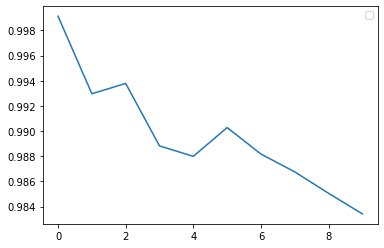

In [ ]:
num_epochs = 10
loss_evolution = []

for epoch in range(1, num_epochs + 1):
    loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution.append(loss)
    test(train_dataset, test_dataset, model, accuracy_calculator)

plt.plot(loss_evolution)
plt.legend()
plt.show()

> S'assembla més al de classificació que al de la siamesa. Pero a nivell de interpretació si veiem millora. 

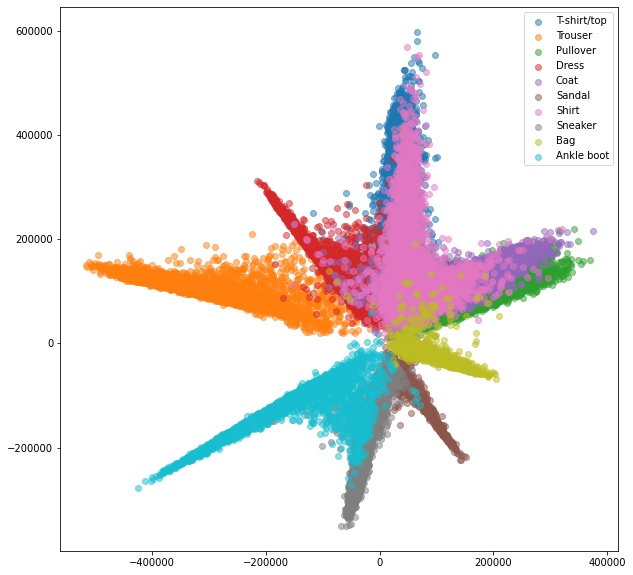

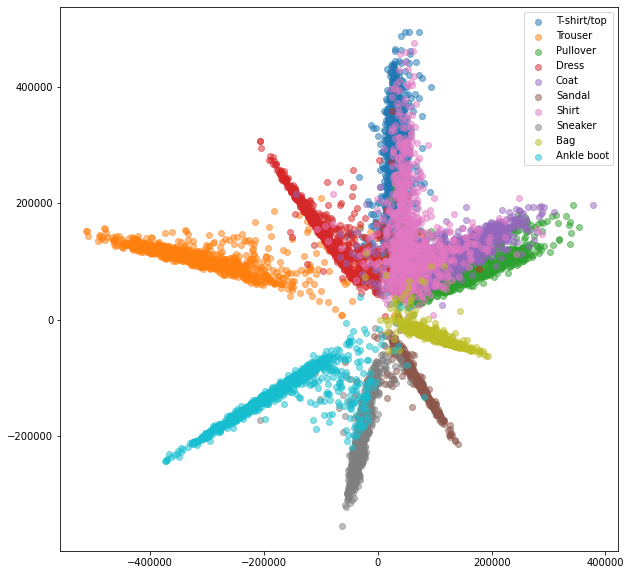

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Better Mining

<br>
<span style="color:blue">

**Exercise 1**: Explain the difference between semi-hard, easy and hard triplets. Try training with each type of triplets mentioned above separately and comment on the effect they have on training, using loss curves and other evidence you find necessary.
    
</span>

Epoch 1 Iteration 0: Loss = 0.7551177144050598, Number of mined triplets = 729
Epoch 1 Iteration 20: Loss = 0.37724700570106506, Number of mined triplets = 109556
Epoch 1 Iteration 40: Loss = 0.4343913197517395, Number of mined triplets = 119671
Epoch 1 Iteration 60: Loss = 0.4161323308944702, Number of mined triplets = 132614
Epoch 1 Iteration 80: Loss = 0.41713300347328186, Number of mined triplets = 120845
Epoch 1 Iteration 100: Loss = 0.4199623167514801, Number of mined triplets = 137411
Epoch 1 Iteration 120: Loss = 0.3537619411945343, Number of mined triplets = 134081
Epoch 1 Iteration 140: Loss = 0.2327529788017273, Number of mined triplets = 141303
Epoch 1 Iteration 160: Loss = 0.26088258624076843, Number of mined triplets = 130667
Epoch 1 Iteration 180: Loss = 0.2353532761335373, Number of mined triplets = 139239
Epoch 1 Iteration 200: Loss = 0.2862926125526428, Number of mined triplets = 130982
Epoch 1 Iteration 220: Loss = 0.32069316506385803, Number of mined triplets = 1400

100%|██████████| 313/313 [00:02<00:00, 127.16it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4037
Epoch 2 Iteration 0: Loss = 0.0456148162484169, Number of mined triplets = 144240
Epoch 2 Iteration 20: Loss = 0.06075424328446388, Number of mined triplets = 142413
Epoch 2 Iteration 40: Loss = 0.18552522361278534, Number of mined triplets = 142284
Epoch 2 Iteration 60: Loss = 0.18539640307426453, Number of mined triplets = 145034
Epoch 2 Iteration 80: Loss = 0.12354213744401932, Number of mined triplets = 138061
Epoch 2 Iteration 100: Loss = 0.10809832811355591, Number of mined triplets = 131062
Epoch 2 Iteration 120: Loss = 0.12095940113067627, Number of mined triplets = 140773
Epoch 2 Iteration 140: Loss = 0.07441691309213638, Number of mined triplets = 125700
Epoch 2 Iteration 160: Loss = 0.12126841396093369, Number of mined triplets = 129468
Epoch 2 Iteration 180: Loss = 0.08231816440820694, Number of mined triplets = 137925
Epoch 2 Iteration 200: Loss = 0.051797766238451004, Number of mined triplets = 147361
Epoch 2 Ite

100%|██████████| 313/313 [00:02<00:00, 128.67it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.45940000000000003
Epoch 3 Iteration 0: Loss = 0.10355990380048752, Number of mined triplets = 142630
Epoch 3 Iteration 20: Loss = 0.20355723798274994, Number of mined triplets = 124648
Epoch 3 Iteration 40: Loss = 0.06855355203151703, Number of mined triplets = 128596
Epoch 3 Iteration 60: Loss = 0.05856171250343323, Number of mined triplets = 134395
Epoch 3 Iteration 80: Loss = 0.05379680171608925, Number of mined triplets = 144880
Epoch 3 Iteration 100: Loss = 0.04303264990448952, Number of mined triplets = 133238
Epoch 3 Iteration 120: Loss = 0.02809741348028183, Number of mined triplets = 124511
Epoch 3 Iteration 140: Loss = 0.03780978545546532, Number of mined triplets = 141411
Epoch 3 Iteration 160: Loss = 0.07440105825662613, Number of mined triplets = 142958
Epoch 3 Iteration 180: Loss = 0.07000461965799332, Number of mined triplets = 129537
Epoch 3 Iteration 200: Loss = 0.06558393687009811, Number of mined triplets = 13443

100%|██████████| 313/313 [00:02<00:00, 128.96it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5002
Epoch 4 Iteration 0: Loss = 0.12651316821575165, Number of mined triplets = 124408
Epoch 4 Iteration 20: Loss = 0.10000883042812347, Number of mined triplets = 142548
Epoch 4 Iteration 40: Loss = 0.050902482122182846, Number of mined triplets = 144439
Epoch 4 Iteration 60: Loss = 0.05634807422757149, Number of mined triplets = 134658
Epoch 4 Iteration 80: Loss = 0.0512368269264698, Number of mined triplets = 135604
Epoch 4 Iteration 100: Loss = 0.06442544609308243, Number of mined triplets = 137888
Epoch 4 Iteration 120: Loss = 0.06818680465221405, Number of mined triplets = 127151
Epoch 4 Iteration 140: Loss = 0.02296851947903633, Number of mined triplets = 135880
Epoch 4 Iteration 160: Loss = 0.03561098128557205, Number of mined triplets = 140909
Epoch 4 Iteration 180: Loss = 0.1315365731716156, Number of mined triplets = 141105
Epoch 4 Iteration 200: Loss = 0.1197952851653099, Number of mined triplets = 139561
Epoch 4 Itera

100%|██████████| 313/313 [00:02<00:00, 130.83it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4203
Epoch 5 Iteration 0: Loss = 0.014771058224141598, Number of mined triplets = 142450
Epoch 5 Iteration 20: Loss = 0.034941207617521286, Number of mined triplets = 135159
Epoch 5 Iteration 40: Loss = 0.04517943784594536, Number of mined triplets = 130266
Epoch 5 Iteration 60: Loss = 0.08089963346719742, Number of mined triplets = 152052
Epoch 5 Iteration 80: Loss = 0.06931102275848389, Number of mined triplets = 137092
Epoch 5 Iteration 100: Loss = 0.053447600454092026, Number of mined triplets = 134834
Epoch 5 Iteration 120: Loss = 0.020826715975999832, Number of mined triplets = 140589
Epoch 5 Iteration 140: Loss = 0.04077295586466789, Number of mined triplets = 138825
Epoch 5 Iteration 160: Loss = 0.06901227682828903, Number of mined triplets = 143327
Epoch 5 Iteration 180: Loss = 0.03878626972436905, Number of mined triplets = 132104
Epoch 5 Iteration 200: Loss = 0.008254087530076504, Number of mined triplets = 144865
Epoch 

100%|██████████| 313/313 [00:02<00:00, 132.65it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4657
Epoch 6 Iteration 0: Loss = 0.031178409233689308, Number of mined triplets = 141397
Epoch 6 Iteration 20: Loss = 0.012224267236888409, Number of mined triplets = 132043
Epoch 6 Iteration 40: Loss = 0.025982601568102837, Number of mined triplets = 135680
Epoch 6 Iteration 60: Loss = 0.03158009797334671, Number of mined triplets = 145933
Epoch 6 Iteration 80: Loss = 0.04001389816403389, Number of mined triplets = 137000
Epoch 6 Iteration 100: Loss = 0.007903704419732094, Number of mined triplets = 144076
Epoch 6 Iteration 120: Loss = 0.011377697810530663, Number of mined triplets = 133184
Epoch 6 Iteration 140: Loss = 0.00807991810142994, Number of mined triplets = 138292
Epoch 6 Iteration 160: Loss = 0.06353545188903809, Number of mined triplets = 125295
Epoch 6 Iteration 180: Loss = 0.0244555976241827, Number of mined triplets = 128344
Epoch 6 Iteration 200: Loss = 0.02222863771021366, Number of mined triplets = 134408
Epoch 6

100%|██████████| 313/313 [00:02<00:00, 131.62it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4677
Epoch 7 Iteration 0: Loss = 0.01759185455739498, Number of mined triplets = 134223
Epoch 7 Iteration 20: Loss = 0.04289817065000534, Number of mined triplets = 141713
Epoch 7 Iteration 40: Loss = 0.03423090651631355, Number of mined triplets = 133231
Epoch 7 Iteration 60: Loss = 0.036237627267837524, Number of mined triplets = 132530
Epoch 7 Iteration 80: Loss = 0.008613661862909794, Number of mined triplets = 132250
Epoch 7 Iteration 100: Loss = 0.046219419687986374, Number of mined triplets = 142716
Epoch 7 Iteration 120: Loss = 0.020501401275396347, Number of mined triplets = 129970
Epoch 7 Iteration 140: Loss = 0.01050032302737236, Number of mined triplets = 130559
Epoch 7 Iteration 160: Loss = 0.0194634310901165, Number of mined triplets = 151935
Epoch 7 Iteration 180: Loss = 0.09800977259874344, Number of mined triplets = 143997
Epoch 7 Iteration 200: Loss = 0.04379875585436821, Number of mined triplets = 133417
Epoch 7 

100%|██████████| 313/313 [00:02<00:00, 130.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.42960000000000004
Epoch 8 Iteration 0: Loss = 0.029483947902917862, Number of mined triplets = 139309
Epoch 8 Iteration 20: Loss = 0.04487616941332817, Number of mined triplets = 130138
Epoch 8 Iteration 40: Loss = 0.018351372331380844, Number of mined triplets = 142419
Epoch 8 Iteration 60: Loss = 0.05986106023192406, Number of mined triplets = 137265
Epoch 8 Iteration 80: Loss = 0.05213611572980881, Number of mined triplets = 138769
Epoch 8 Iteration 100: Loss = 0.034405920654535294, Number of mined triplets = 135856
Epoch 8 Iteration 120: Loss = 0.038018204271793365, Number of mined triplets = 141766
Epoch 8 Iteration 140: Loss = 0.05613292008638382, Number of mined triplets = 131609
Epoch 8 Iteration 160: Loss = 0.011363686062395573, Number of mined triplets = 135215
Epoch 8 Iteration 180: Loss = 0.033758774399757385, Number of mined triplets = 141379
Epoch 8 Iteration 200: Loss = 0.035054195672273636, Number of mined triplets 

100%|██████████| 313/313 [00:02<00:00, 128.84it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.47350000000000003
Epoch 9 Iteration 0: Loss = 0.05851879343390465, Number of mined triplets = 134169
Epoch 9 Iteration 20: Loss = 0.04300321266055107, Number of mined triplets = 131561
Epoch 9 Iteration 40: Loss = 0.05233069509267807, Number of mined triplets = 148594
Epoch 9 Iteration 60: Loss = 0.07582034915685654, Number of mined triplets = 136568
Epoch 9 Iteration 80: Loss = 0.028918549418449402, Number of mined triplets = 145321
Epoch 9 Iteration 100: Loss = 0.009559672325849533, Number of mined triplets = 140025
Epoch 9 Iteration 120: Loss = 0.005210889969021082, Number of mined triplets = 128702
Epoch 9 Iteration 140: Loss = 0.010596083477139473, Number of mined triplets = 145198
Epoch 9 Iteration 160: Loss = 0.012208604253828526, Number of mined triplets = 133441
Epoch 9 Iteration 180: Loss = 0.0637635737657547, Number of mined triplets = 148681
Epoch 9 Iteration 200: Loss = 0.054280735552310944, Number of mined triplets = 

100%|██████████| 313/313 [00:02<00:00, 131.20it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.42550000000000004
Epoch 10 Iteration 0: Loss = 0.13904717564582825, Number of mined triplets = 146418
Epoch 10 Iteration 20: Loss = 0.04414175823330879, Number of mined triplets = 139940
Epoch 10 Iteration 40: Loss = 0.11711738258600235, Number of mined triplets = 126252
Epoch 10 Iteration 60: Loss = 0.0506911538541317, Number of mined triplets = 127905
Epoch 10 Iteration 80: Loss = 0.09981168806552887, Number of mined triplets = 148835
Epoch 10 Iteration 100: Loss = 0.017498960718512535, Number of mined triplets = 137382
Epoch 10 Iteration 120: Loss = 0.018217673525214195, Number of mined triplets = 131378
Epoch 10 Iteration 140: Loss = 0.01279299333691597, Number of mined triplets = 136642
Epoch 10 Iteration 160: Loss = 0.048150718212127686, Number of mined triplets = 137847
Epoch 10 Iteration 180: Loss = 0.04831350967288017, Number of mined triplets = 121939
Epoch 10 Iteration 200: Loss = 0.07101045548915863, Number of mined tri

100%|██████████| 313/313 [00:02<00:00, 132.12it/s]


Computing accuracy


No handles with labels found to put in legend.


Test set accuracy (Precision@1) = 0.44820000000000004


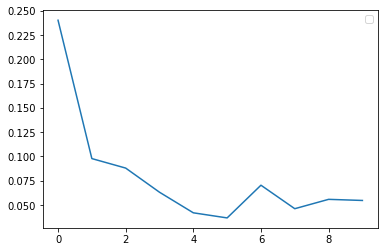

In [ ]:
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="easy") # molt important
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

model_easy = EmbeddingNet().to(device)
optimizer = optim.Adam(model_easy.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1., distance = distance)

num_epochs = 10
loss_evolution_easy = []

for epoch in range(1, num_epochs + 1):
    loss = train(model_easy, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution_easy.append(loss)
    test(train_dataset, test_dataset, model_easy, accuracy_calculator)

plt.plot(loss_evolution_easy)
plt.legend()
plt.show()

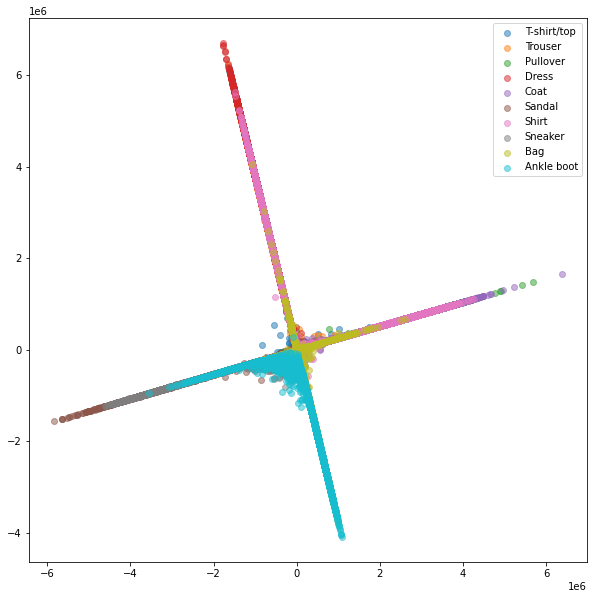

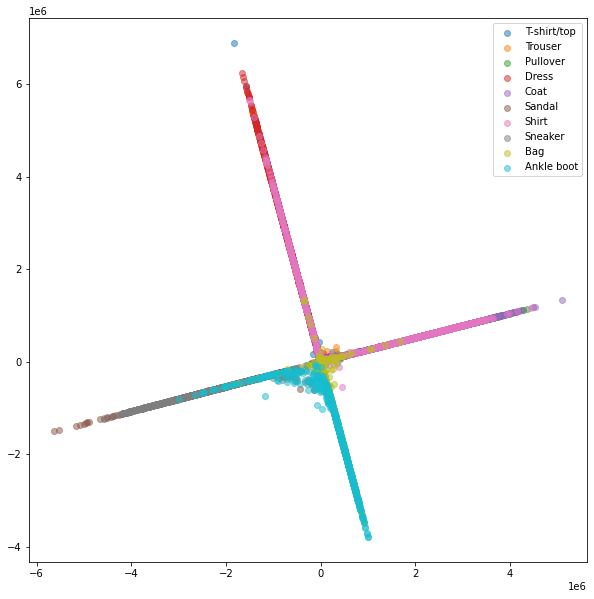

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model_easy)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model_easy)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

Epoch 1 Iteration 0: Loss = 0.96673983335495, Number of mined triplets = 97150
Epoch 1 Iteration 20: Loss = 0.9411212205886841, Number of mined triplets = 26282
Epoch 1 Iteration 40: Loss = 0.9076052904129028, Number of mined triplets = 19841
Epoch 1 Iteration 60: Loss = 0.9218825697898865, Number of mined triplets = 16025
Epoch 1 Iteration 80: Loss = 0.9101532101631165, Number of mined triplets = 19461
Epoch 1 Iteration 100: Loss = 0.9167985320091248, Number of mined triplets = 25112
Epoch 1 Iteration 120: Loss = 0.9098415970802307, Number of mined triplets = 18833
Epoch 1 Iteration 140: Loss = 0.9126155972480774, Number of mined triplets = 27777
Epoch 1 Iteration 160: Loss = 0.9136624336242676, Number of mined triplets = 23045
Epoch 1 Iteration 180: Loss = 0.910251259803772, Number of mined triplets = 17612
Epoch 1 Iteration 200: Loss = 0.9031410813331604, Number of mined triplets = 16217
Epoch 1 Iteration 220: Loss = 0.907650887966156, Number of mined triplets = 17433
Epoch 1 Iterat

100%|██████████| 313/313 [00:02<00:00, 134.52it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6868000000000001
Epoch 2 Iteration 0: Loss = 0.9150267839431763, Number of mined triplets = 19663
Epoch 2 Iteration 20: Loss = 0.8709328770637512, Number of mined triplets = 15652
Epoch 2 Iteration 40: Loss = 0.8973169922828674, Number of mined triplets = 15690
Epoch 2 Iteration 60: Loss = 0.8841535449028015, Number of mined triplets = 19788
Epoch 2 Iteration 80: Loss = 0.8766613602638245, Number of mined triplets = 20753
Epoch 2 Iteration 100: Loss = 0.9012846350669861, Number of mined triplets = 19100
Epoch 2 Iteration 120: Loss = 0.8991581797599792, Number of mined triplets = 19423
Epoch 2 Iteration 140: Loss = 0.9016714096069336, Number of mined triplets = 18080
Epoch 2 Iteration 160: Loss = 0.8918594121932983, Number of mined triplets = 18447
Epoch 2 Iteration 180: Loss = 0.902647078037262, Number of mined triplets = 16871
Epoch 2 Iteration 200: Loss = 0.8966270089149475, Number of mined triplets = 15591
Epoch 2 Iteration 220:

100%|██████████| 313/313 [00:02<00:00, 135.60it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7333000000000001
Epoch 3 Iteration 0: Loss = 0.8966427445411682, Number of mined triplets = 15560
Epoch 3 Iteration 20: Loss = 0.8786572813987732, Number of mined triplets = 12670
Epoch 3 Iteration 40: Loss = 0.8953111171722412, Number of mined triplets = 16250
Epoch 3 Iteration 60: Loss = 0.8919985294342041, Number of mined triplets = 13583
Epoch 3 Iteration 80: Loss = 0.9271230697631836, Number of mined triplets = 16908
Epoch 3 Iteration 100: Loss = 0.8909049034118652, Number of mined triplets = 16376
Epoch 3 Iteration 120: Loss = 0.9025717973709106, Number of mined triplets = 17483
Epoch 3 Iteration 140: Loss = 0.8790721893310547, Number of mined triplets = 18130
Epoch 3 Iteration 160: Loss = 0.8893265128135681, Number of mined triplets = 19647
Epoch 3 Iteration 180: Loss = 0.8718140125274658, Number of mined triplets = 13777
Epoch 3 Iteration 200: Loss = 0.9054691195487976, Number of mined triplets = 14419
Epoch 3 Iteration 220

100%|██████████| 313/313 [00:02<00:00, 134.13it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7854
Epoch 4 Iteration 0: Loss = 0.881180465221405, Number of mined triplets = 20981
Epoch 4 Iteration 20: Loss = 0.8820689916610718, Number of mined triplets = 14153
Epoch 4 Iteration 40: Loss = 0.8567916750907898, Number of mined triplets = 13727
Epoch 4 Iteration 60: Loss = 0.8765059113502502, Number of mined triplets = 17720
Epoch 4 Iteration 80: Loss = 0.8836870193481445, Number of mined triplets = 19575
Epoch 4 Iteration 100: Loss = 0.8990042209625244, Number of mined triplets = 19280
Epoch 4 Iteration 120: Loss = 0.8959453701972961, Number of mined triplets = 11969
Epoch 4 Iteration 140: Loss = 0.8764663934707642, Number of mined triplets = 12894
Epoch 4 Iteration 160: Loss = 0.890034556388855, Number of mined triplets = 17996
Epoch 4 Iteration 180: Loss = 0.8839136958122253, Number of mined triplets = 13769
Epoch 4 Iteration 200: Loss = 0.8751252293586731, Number of mined triplets = 17458
Epoch 4 Iteration 220: Loss = 0.891

100%|██████████| 313/313 [00:02<00:00, 131.96it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8026000000000001
Epoch 5 Iteration 0: Loss = 0.8577182292938232, Number of mined triplets = 16880
Epoch 5 Iteration 20: Loss = 0.8859190344810486, Number of mined triplets = 14451
Epoch 5 Iteration 40: Loss = 0.8789736032485962, Number of mined triplets = 17089
Epoch 5 Iteration 60: Loss = 0.8868732452392578, Number of mined triplets = 12938
Epoch 5 Iteration 80: Loss = 0.8616992235183716, Number of mined triplets = 11899
Epoch 5 Iteration 100: Loss = 0.902746856212616, Number of mined triplets = 11693
Epoch 5 Iteration 120: Loss = 0.882179856300354, Number of mined triplets = 17166
Epoch 5 Iteration 140: Loss = 0.8772438764572144, Number of mined triplets = 15297
Epoch 5 Iteration 160: Loss = 0.9013863801956177, Number of mined triplets = 14727
Epoch 5 Iteration 180: Loss = 0.8689062595367432, Number of mined triplets = 12965
Epoch 5 Iteration 200: Loss = 0.8841592669487, Number of mined triplets = 16936
Epoch 5 Iteration 220: Los

100%|██████████| 313/313 [00:02<00:00, 127.89it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7965
Epoch 6 Iteration 0: Loss = 0.8685165047645569, Number of mined triplets = 13069
Epoch 6 Iteration 20: Loss = 0.8897243738174438, Number of mined triplets = 13008
Epoch 6 Iteration 40: Loss = 0.8934421539306641, Number of mined triplets = 18384
Epoch 6 Iteration 60: Loss = 0.8771165609359741, Number of mined triplets = 12565
Epoch 6 Iteration 80: Loss = 0.8929873704910278, Number of mined triplets = 11380
Epoch 6 Iteration 100: Loss = 0.8760601878166199, Number of mined triplets = 14247
Epoch 6 Iteration 120: Loss = 0.8640924096107483, Number of mined triplets = 17722
Epoch 6 Iteration 140: Loss = 0.8718644976615906, Number of mined triplets = 14772
Epoch 6 Iteration 160: Loss = 0.8806743621826172, Number of mined triplets = 12597
Epoch 6 Iteration 180: Loss = 0.8612698316574097, Number of mined triplets = 11458
Epoch 6 Iteration 200: Loss = 0.871444046497345, Number of mined triplets = 15122
Epoch 6 Iteration 220: Loss = 0.88

100%|██████████| 313/313 [00:02<00:00, 109.67it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8068000000000001
Epoch 7 Iteration 0: Loss = 0.8737003803253174, Number of mined triplets = 18024
Epoch 7 Iteration 20: Loss = 0.8653283715248108, Number of mined triplets = 13140
Epoch 7 Iteration 40: Loss = 0.8672597408294678, Number of mined triplets = 15627
Epoch 7 Iteration 60: Loss = 0.8871428370475769, Number of mined triplets = 14114
Epoch 7 Iteration 80: Loss = 0.8714389801025391, Number of mined triplets = 14952
Epoch 7 Iteration 100: Loss = 0.8786560297012329, Number of mined triplets = 16646
Epoch 7 Iteration 120: Loss = 0.8809844851493835, Number of mined triplets = 15019
Epoch 7 Iteration 140: Loss = 0.8884505033493042, Number of mined triplets = 8700
Epoch 7 Iteration 160: Loss = 0.872012197971344, Number of mined triplets = 14743
Epoch 7 Iteration 180: Loss = 0.8734992742538452, Number of mined triplets = 12704
Epoch 7 Iteration 200: Loss = 0.8592105507850647, Number of mined triplets = 18943
Epoch 7 Iteration 220: 

100%|██████████| 313/313 [00:02<00:00, 133.49it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8130000000000001
Epoch 8 Iteration 0: Loss = 0.8675815463066101, Number of mined triplets = 13610
Epoch 8 Iteration 20: Loss = 0.8872277736663818, Number of mined triplets = 11449
Epoch 8 Iteration 40: Loss = 0.8789156079292297, Number of mined triplets = 15429
Epoch 8 Iteration 60: Loss = 0.8521736860275269, Number of mined triplets = 10372
Epoch 8 Iteration 80: Loss = 0.8694698810577393, Number of mined triplets = 15246
Epoch 8 Iteration 100: Loss = 0.8922631144523621, Number of mined triplets = 13557
Epoch 8 Iteration 120: Loss = 0.8717058897018433, Number of mined triplets = 17460
Epoch 8 Iteration 140: Loss = 0.8868156671524048, Number of mined triplets = 13410
Epoch 8 Iteration 160: Loss = 0.8552210330963135, Number of mined triplets = 12986
Epoch 8 Iteration 180: Loss = 0.877759575843811, Number of mined triplets = 17225
Epoch 8 Iteration 200: Loss = 0.9008219242095947, Number of mined triplets = 14723
Epoch 8 Iteration 220:

100%|██████████| 313/313 [00:02<00:00, 134.32it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8164
Epoch 9 Iteration 0: Loss = 0.8799892663955688, Number of mined triplets = 14597
Epoch 9 Iteration 20: Loss = 0.8667889833450317, Number of mined triplets = 14464
Epoch 9 Iteration 40: Loss = 0.8779861330986023, Number of mined triplets = 8394
Epoch 9 Iteration 60: Loss = 0.8782505989074707, Number of mined triplets = 10949
Epoch 9 Iteration 80: Loss = 0.8590466380119324, Number of mined triplets = 17714
Epoch 9 Iteration 100: Loss = 0.8992128372192383, Number of mined triplets = 17653
Epoch 9 Iteration 120: Loss = 0.8583540320396423, Number of mined triplets = 14148
Epoch 9 Iteration 140: Loss = 0.8721744418144226, Number of mined triplets = 11182
Epoch 9 Iteration 160: Loss = 0.8711256980895996, Number of mined triplets = 12399
Epoch 9 Iteration 180: Loss = 0.8870207667350769, Number of mined triplets = 14574
Epoch 9 Iteration 200: Loss = 0.8921804428100586, Number of mined triplets = 20641
Epoch 9 Iteration 220: Loss = 0.85

100%|██████████| 313/313 [00:02<00:00, 133.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8325
Epoch 10 Iteration 0: Loss = 0.8556407690048218, Number of mined triplets = 16147
Epoch 10 Iteration 20: Loss = 0.9126039147377014, Number of mined triplets = 16869
Epoch 10 Iteration 40: Loss = 0.8757032155990601, Number of mined triplets = 14721
Epoch 10 Iteration 60: Loss = 0.8902432918548584, Number of mined triplets = 17323
Epoch 10 Iteration 80: Loss = 0.8773448467254639, Number of mined triplets = 14608
Epoch 10 Iteration 100: Loss = 0.8733273148536682, Number of mined triplets = 18288
Epoch 10 Iteration 120: Loss = 0.8867268562316895, Number of mined triplets = 9863
Epoch 10 Iteration 140: Loss = 0.8770821690559387, Number of mined triplets = 11644
Epoch 10 Iteration 160: Loss = 0.8627780079841614, Number of mined triplets = 13832
Epoch 10 Iteration 180: Loss = 0.8799477219581604, Number of mined triplets = 12432
Epoch 10 Iteration 200: Loss = 0.8612533211708069, Number of mined triplets = 13656
Epoch 10 Iteration 220:

100%|██████████| 313/313 [00:02<00:00, 133.83it/s]


Computing accuracy


No handles with labels found to put in legend.


Test set accuracy (Precision@1) = 0.8432000000000001


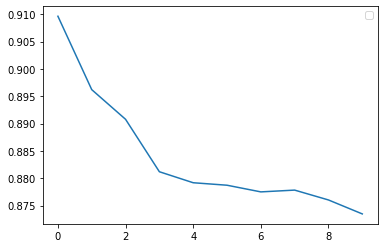

In [ ]:
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="semihard") # molt important
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

model_semihard = EmbeddingNet().to(device)
optimizer = optim.Adam(model_semihard.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1., distance = distance)

num_epochs = 10
loss_evolution_semihard = []

for epoch in range(1, num_epochs + 1):
    loss = train(model_semihard, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution_semihard.append(loss)
    test(train_dataset, test_dataset, model_semihard, accuracy_calculator)

plt.plot(loss_evolution_semihard)
plt.legend()
plt.show()

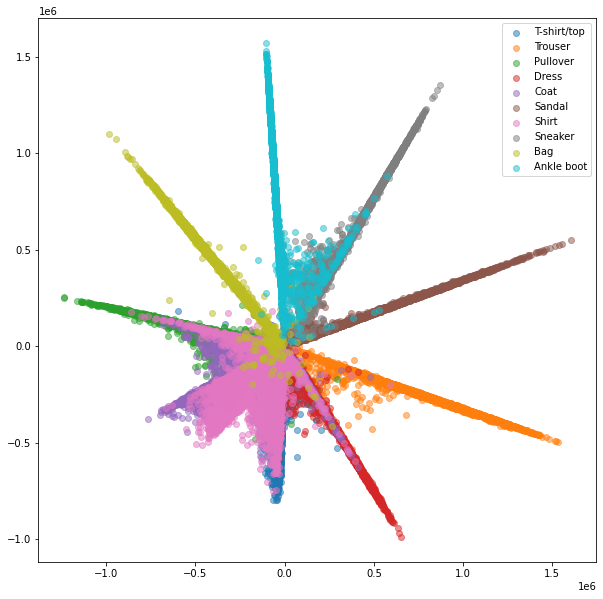

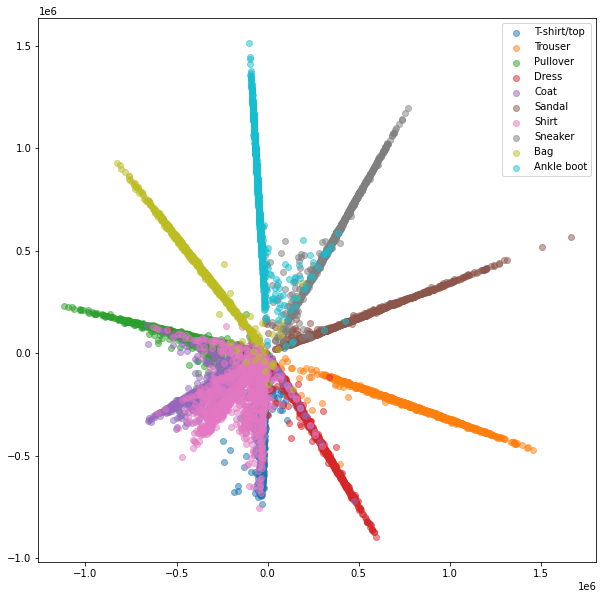

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model_semihard)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model_semihard)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

Epoch 1 Iteration 0: Loss = 1.02064847946167, Number of mined triplets = 81249
Epoch 1 Iteration 20: Loss = 1.0000088214874268, Number of mined triplets = 62599
Epoch 1 Iteration 40: Loss = 1.0000123977661133, Number of mined triplets = 69621
Epoch 1 Iteration 60: Loss = 1.000003457069397, Number of mined triplets = 65252
Epoch 1 Iteration 80: Loss = 1.000001072883606, Number of mined triplets = 67999
Epoch 1 Iteration 100: Loss = 1.0000003576278687, Number of mined triplets = 66240
Epoch 1 Iteration 120: Loss = 1.0000001192092896, Number of mined triplets = 52632
Epoch 1 Iteration 140: Loss = 1.0000001192092896, Number of mined triplets = 47901
Epoch 1 Iteration 160: Loss = 1.0000001192092896, Number of mined triplets = 58752
Epoch 1 Iteration 180: Loss = 1.0000001192092896, Number of mined triplets = 54139
Epoch 1 Iteration 200: Loss = 1.0000001192092896, Number of mined triplets = 62156
Epoch 1 Iteration 220: Loss = 1.000000238418579, Number of mined triplets = 49988
Epoch 1 Iterati

100%|██████████| 313/313 [00:02<00:00, 133.82it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.24760000000000001
Epoch 2 Iteration 0: Loss = 1.0000001192092896, Number of mined triplets = 61833
Epoch 2 Iteration 20: Loss = 1.0, Number of mined triplets = 58710
Epoch 2 Iteration 40: Loss = 1.0000001192092896, Number of mined triplets = 62946
Epoch 2 Iteration 60: Loss = 1.0, Number of mined triplets = 56100
Epoch 2 Iteration 80: Loss = 0.9999999403953552, Number of mined triplets = 63355
Epoch 2 Iteration 100: Loss = 1.0, Number of mined triplets = 56617
Epoch 2 Iteration 120: Loss = 1.0, Number of mined triplets = 61425
Epoch 2 Iteration 140: Loss = 1.0, Number of mined triplets = 62197
Epoch 2 Iteration 160: Loss = 1.0, Number of mined triplets = 65176
Epoch 2 Iteration 180: Loss = 0.9999999403953552, Number of mined triplets = 50311
Epoch 2 Iteration 200: Loss = 1.0, Number of mined triplets = 57669
Epoch 2 Iteration 220: Loss = 1.0, Number of mined triplets = 58139
Epoch 2 Iteration 240: Loss = 1.0, Number of mined triple

100%|██████████| 313/313 [00:02<00:00, 135.63it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.25830000000000003
Epoch 3 Iteration 0: Loss = 1.0, Number of mined triplets = 64415
Epoch 3 Iteration 20: Loss = 0.9999999403953552, Number of mined triplets = 60792
Epoch 3 Iteration 40: Loss = 1.0, Number of mined triplets = 65946
Epoch 3 Iteration 60: Loss = 1.0, Number of mined triplets = 54010
Epoch 3 Iteration 80: Loss = 1.0, Number of mined triplets = 64979
Epoch 3 Iteration 100: Loss = 1.0, Number of mined triplets = 67677
Epoch 3 Iteration 120: Loss = 1.0, Number of mined triplets = 64023
Epoch 3 Iteration 140: Loss = 1.0, Number of mined triplets = 64875
Epoch 3 Iteration 160: Loss = 1.0, Number of mined triplets = 63345
Epoch 3 Iteration 180: Loss = 1.0, Number of mined triplets = 68037
Epoch 3 Iteration 200: Loss = 1.0, Number of mined triplets = 65079
Epoch 3 Iteration 220: Loss = 1.0, Number of mined triplets = 70058
Epoch 3 Iteration 240: Loss = 1.0, Number of mined triplets = 57705
Epoch 3 Iteration 260: Loss = 1.0,

100%|██████████| 313/313 [00:02<00:00, 134.56it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2348
Epoch 4 Iteration 0: Loss = 1.0, Number of mined triplets = 73167
Epoch 4 Iteration 20: Loss = 1.0, Number of mined triplets = 67565
Epoch 4 Iteration 40: Loss = 1.0, Number of mined triplets = 74223
Epoch 4 Iteration 60: Loss = 1.0, Number of mined triplets = 69754
Epoch 4 Iteration 80: Loss = 1.0, Number of mined triplets = 60239
Epoch 4 Iteration 100: Loss = 1.0, Number of mined triplets = 72615
Epoch 4 Iteration 120: Loss = 1.0, Number of mined triplets = 59804
Epoch 4 Iteration 140: Loss = 1.0, Number of mined triplets = 67383
Epoch 4 Iteration 160: Loss = 1.0, Number of mined triplets = 63911
Epoch 4 Iteration 180: Loss = 1.0, Number of mined triplets = 63704
Epoch 4 Iteration 200: Loss = 0.9999999403953552, Number of mined triplets = 64246
Epoch 4 Iteration 220: Loss = 1.0, Number of mined triplets = 70562
Epoch 4 Iteration 240: Loss = 1.0, Number of mined triplets = 66447
Epoch 4 Iteration 260: Loss = 1.0, Number of mi

100%|██████████| 313/313 [00:02<00:00, 133.64it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.24910000000000002
Epoch 5 Iteration 0: Loss = 1.0, Number of mined triplets = 72247
Epoch 5 Iteration 20: Loss = 1.0, Number of mined triplets = 78238
Epoch 5 Iteration 40: Loss = 1.0, Number of mined triplets = 70331
Epoch 5 Iteration 60: Loss = 1.0, Number of mined triplets = 66005
Epoch 5 Iteration 80: Loss = 1.0, Number of mined triplets = 60291
Epoch 5 Iteration 100: Loss = 1.0, Number of mined triplets = 65641
Epoch 5 Iteration 120: Loss = 1.0, Number of mined triplets = 75437
Epoch 5 Iteration 140: Loss = 1.0, Number of mined triplets = 68079
Epoch 5 Iteration 160: Loss = 1.0, Number of mined triplets = 69405
Epoch 5 Iteration 180: Loss = 1.0, Number of mined triplets = 62861
Epoch 5 Iteration 200: Loss = 1.0, Number of mined triplets = 62929
Epoch 5 Iteration 220: Loss = 1.0, Number of mined triplets = 61736
Epoch 5 Iteration 240: Loss = 1.0, Number of mined triplets = 72268
Epoch 5 Iteration 260: Loss = 1.0, Number of mine

100%|██████████| 313/313 [00:02<00:00, 134.16it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.27390000000000003
Epoch 6 Iteration 0: Loss = 1.0, Number of mined triplets = 70625
Epoch 6 Iteration 20: Loss = 1.0, Number of mined triplets = 76176
Epoch 6 Iteration 40: Loss = 1.0, Number of mined triplets = 69058
Epoch 6 Iteration 60: Loss = 1.0, Number of mined triplets = 63994
Epoch 6 Iteration 80: Loss = 1.0, Number of mined triplets = 68884
Epoch 6 Iteration 100: Loss = 0.9999999403953552, Number of mined triplets = 78421
Epoch 6 Iteration 120: Loss = 1.0, Number of mined triplets = 68135
Epoch 6 Iteration 140: Loss = 1.0, Number of mined triplets = 81395
Epoch 6 Iteration 160: Loss = 1.0, Number of mined triplets = 66113
Epoch 6 Iteration 180: Loss = 1.0, Number of mined triplets = 67825
Epoch 6 Iteration 200: Loss = 1.0, Number of mined triplets = 64947
Epoch 6 Iteration 220: Loss = 1.0, Number of mined triplets = 60067
Epoch 6 Iteration 240: Loss = 1.0, Number of mined triplets = 64812
Epoch 6 Iteration 260: Loss = 1.0,

100%|██████████| 313/313 [00:02<00:00, 134.06it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2773
Epoch 7 Iteration 0: Loss = 1.0, Number of mined triplets = 64366
Epoch 7 Iteration 20: Loss = 1.0, Number of mined triplets = 75033
Epoch 7 Iteration 40: Loss = 1.0, Number of mined triplets = 81654
Epoch 7 Iteration 60: Loss = 1.0, Number of mined triplets = 71272
Epoch 7 Iteration 80: Loss = 1.0, Number of mined triplets = 64515
Epoch 7 Iteration 100: Loss = 1.0, Number of mined triplets = 60935
Epoch 7 Iteration 120: Loss = 0.9999999403953552, Number of mined triplets = 64958
Epoch 7 Iteration 140: Loss = 1.0, Number of mined triplets = 65258
Epoch 7 Iteration 160: Loss = 1.0, Number of mined triplets = 57056
Epoch 7 Iteration 180: Loss = 1.0, Number of mined triplets = 64955
Epoch 7 Iteration 200: Loss = 1.0, Number of mined triplets = 66476
Epoch 7 Iteration 220: Loss = 1.0, Number of mined triplets = 67336
Epoch 7 Iteration 240: Loss = 1.0, Number of mined triplets = 72049
Epoch 7 Iteration 260: Loss = 1.0, Number of mi

100%|██████████| 313/313 [00:02<00:00, 133.65it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2756
Epoch 8 Iteration 0: Loss = 1.0, Number of mined triplets = 64854
Epoch 8 Iteration 20: Loss = 1.0, Number of mined triplets = 69054
Epoch 8 Iteration 40: Loss = 0.9999999403953552, Number of mined triplets = 59019
Epoch 8 Iteration 60: Loss = 1.0, Number of mined triplets = 63080
Epoch 8 Iteration 80: Loss = 1.0, Number of mined triplets = 59982
Epoch 8 Iteration 100: Loss = 0.9999999403953552, Number of mined triplets = 60621
Epoch 8 Iteration 120: Loss = 1.0, Number of mined triplets = 59657
Epoch 8 Iteration 140: Loss = 1.0, Number of mined triplets = 56549
Epoch 8 Iteration 160: Loss = 0.9999999403953552, Number of mined triplets = 58861
Epoch 8 Iteration 180: Loss = 1.0, Number of mined triplets = 60546
Epoch 8 Iteration 200: Loss = 1.0, Number of mined triplets = 66685
Epoch 8 Iteration 220: Loss = 1.0, Number of mined triplets = 66185
Epoch 8 Iteration 240: Loss = 1.0, Number of mined triplets = 60442
Epoch 8 Iteration

100%|██████████| 313/313 [00:02<00:00, 135.17it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.27040000000000003
Epoch 9 Iteration 0: Loss = 0.9999999403953552, Number of mined triplets = 61056
Epoch 9 Iteration 20: Loss = 1.0, Number of mined triplets = 61599
Epoch 9 Iteration 40: Loss = 1.0, Number of mined triplets = 57453
Epoch 9 Iteration 60: Loss = 1.0, Number of mined triplets = 59790
Epoch 9 Iteration 80: Loss = 1.0, Number of mined triplets = 56977
Epoch 9 Iteration 100: Loss = 1.0, Number of mined triplets = 58420
Epoch 9 Iteration 120: Loss = 1.0, Number of mined triplets = 63664
Epoch 9 Iteration 140: Loss = 1.0, Number of mined triplets = 67526
Epoch 9 Iteration 160: Loss = 1.0, Number of mined triplets = 70240
Epoch 9 Iteration 180: Loss = 1.0, Number of mined triplets = 59766
Epoch 9 Iteration 200: Loss = 0.9999999403953552, Number of mined triplets = 61197
Epoch 9 Iteration 220: Loss = 0.9999999403953552, Number of mined triplets = 56019
Epoch 9 Iteration 240: Loss = 1.0, Number of mined triplets = 56658
Epoc

100%|██████████| 313/313 [00:02<00:00, 130.33it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.30970000000000003
Epoch 10 Iteration 0: Loss = 1.0, Number of mined triplets = 61291
Epoch 10 Iteration 20: Loss = 1.0, Number of mined triplets = 55613
Epoch 10 Iteration 40: Loss = 1.0, Number of mined triplets = 69324
Epoch 10 Iteration 60: Loss = 1.0, Number of mined triplets = 58020
Epoch 10 Iteration 80: Loss = 0.9999999403953552, Number of mined triplets = 61424
Epoch 10 Iteration 100: Loss = 1.0, Number of mined triplets = 59125
Epoch 10 Iteration 120: Loss = 1.0, Number of mined triplets = 59527
Epoch 10 Iteration 140: Loss = 1.0, Number of mined triplets = 59955
Epoch 10 Iteration 160: Loss = 0.9999999403953552, Number of mined triplets = 57877
Epoch 10 Iteration 180: Loss = 1.0, Number of mined triplets = 59783
Epoch 10 Iteration 200: Loss = 1.0, Number of mined triplets = 64653
Epoch 10 Iteration 220: Loss = 1.0, Number of mined triplets = 55049
Epoch 10 Iteration 240: Loss = 1.0, Number of mined triplets = 65508
Epoch 

100%|██████████| 313/313 [00:02<00:00, 130.76it/s]


Computing accuracy


No handles with labels found to put in legend.


Test set accuracy (Precision@1) = 0.3209


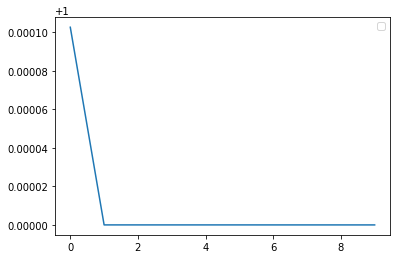

In [ ]:
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="hard") # molt important
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

model_hard = EmbeddingNet().to(device)
optimizer = optim.Adam(model_hard.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1., distance = distance)

num_epochs = 10
loss_evolution_hard = []

for epoch in range(1, num_epochs + 1):
    loss = train(model_hard, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution_hard.append(loss)
    test(train_dataset, test_dataset, model_hard, accuracy_calculator)

plt.plot(loss_evolution_hard)
plt.legend()
plt.show()

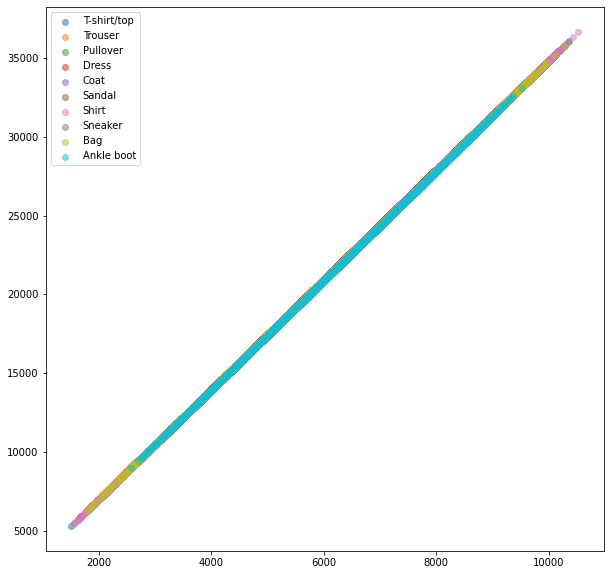

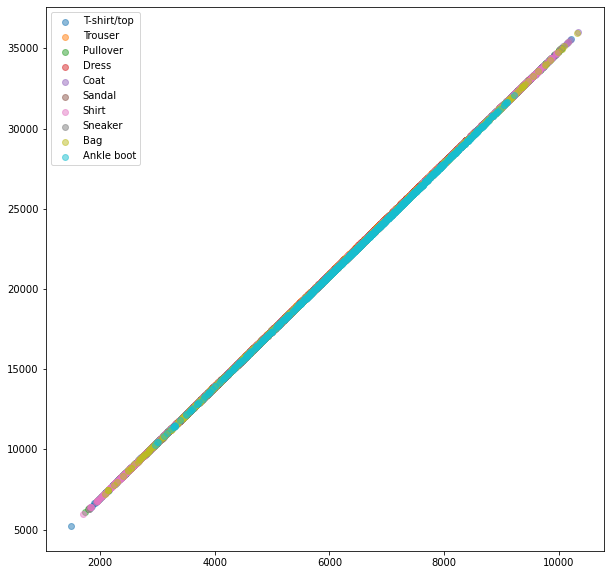

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model_hard)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model_hard)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

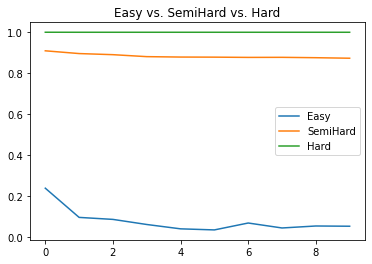

In [ ]:
plt.plot(loss_evolution_easy, label = "Easy")
plt.plot(loss_evolution_semihard, label = "SemiHard")
plt.plot(loss_evolution_hard, label = "Hard")
plt.legend()
plt.title('Easy vs. SemiHard vs. Hard')
plt.show()

**Explicació:**

El miner és la funció que s'encarrega, donats embeddings i labels, de seleccionar quines tripletes són semihard, hard o easy. Més tard es seleccionen quin tipus volem utilitzar per al càlcul de la funció de pèrdua (loss).

Les tripletes semihard contenen l'amplada, un valor positiu (de la mateixa classe) i una de negativa (de diferent classe). El positiu es troba més a prop de l'"anchor" que el negatiu però ambdós dins del marge fixat. L'objectiu en aquest cas és separar encara més la mostra de classe diferent i unir més (en la mesura del possible) les dues mostres de la mateixa classe.

Per a les tripletes anomenades com a hard trobem que el valor negatiu està més a prop de l'"anchor" que el positiu (s'assembla més la negativa que la positiva).

Finalment, les tripletes easy on el valor positiu es troba més a prop que el negatiu de l'amplada i aquest segon es localitza fora del radi de marge prefixat pel problema.

Després de fer l'estudi per a un training amb els tres tipus de tripletes, es pot concloure que la millor opció és l'entrenament amb semihard. En el cas de minner hard, tenim una visualització de l'embedding lineal descendent amb tots els punts del dataset superposats, és a dir, no ha après res. Això és perquè entrenar sempre amb tripletes molt difícils pot realitzar que es necessiti menys temps d'execució, però, per altra banda, el problema és massa difícil per poder solucionar-se i es produeixen els exploding gradients.

D'altra banda, el training amb les tripletes easy tampoc obté bons resultats, això és perquè el problema és molt fàcil de resoldre i la corba de la loss no puja del 0, penso que és perquè com que no troba cap tasca difícil de resoldre i de la qual es pugui aprendre els gradients no varien (vanishing gradients), en conseqüència el model no aprèn i necessitaria moltes iteracions per poder aconseguir resultats decents.

<br>
<span style="color:blue">

**Open Exercise 2 (OPTIONAL)**: Read the documentation of the PyTorch Metric Learning library and try a couple of different mining strategies, distances, margins and loss functions.
    
</span>

In [ ]:
from pytorch_metric_learning.distances import SNRDistance

Epoch 1 Iteration 0: Loss = 0.9985925555229187, Number of mined triplets = 887366
Epoch 1 Iteration 20: Loss = 1.6356534957885742, Number of mined triplets = 458526
Epoch 1 Iteration 40: Loss = 1.876162052154541, Number of mined triplets = 504332
Epoch 1 Iteration 60: Loss = 1.8184800148010254, Number of mined triplets = 537761
Epoch 1 Iteration 80: Loss = 1.8056977987289429, Number of mined triplets = 388405
Epoch 1 Iteration 100: Loss = 1.4091475009918213, Number of mined triplets = 575287
Epoch 1 Iteration 120: Loss = 1.510094404220581, Number of mined triplets = 761513
Epoch 1 Iteration 140: Loss = 1.3625388145446777, Number of mined triplets = 804290
Epoch 1 Iteration 160: Loss = 1.5423693656921387, Number of mined triplets = 670993
Epoch 1 Iteration 180: Loss = 1.5644893646240234, Number of mined triplets = 683168
Epoch 1 Iteration 200: Loss = 1.9653072357177734, Number of mined triplets = 508244
Epoch 1 Iteration 220: Loss = 1.2119795083999634, Number of mined triplets = 712966


100%|██████████| 313/313 [00:03<00:00, 81.84it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2569
Epoch 2 Iteration 0: Loss = 1.2402634620666504, Number of mined triplets = 615161
Epoch 2 Iteration 20: Loss = 1.5139391422271729, Number of mined triplets = 696550
Epoch 2 Iteration 40: Loss = 0.9999985694885254, Number of mined triplets = 1163998
Epoch 2 Iteration 60: Loss = 0.9999961256980896, Number of mined triplets = 1080982
Epoch 2 Iteration 80: Loss = 0.9999951124191284, Number of mined triplets = 1071627
Epoch 2 Iteration 100: Loss = 0.9999954104423523, Number of mined triplets = 1016619
Epoch 2 Iteration 120: Loss = 0.9999953508377075, Number of mined triplets = 1094621
Epoch 2 Iteration 140: Loss = 0.9999957084655762, Number of mined triplets = 1036700
Epoch 2 Iteration 160: Loss = 0.9999958276748657, Number of mined triplets = 1068886
Epoch 2 Iteration 180: Loss = 0.9999963045120239, Number of mined triplets = 1022642
Epoch 2 Iteration 200: Loss = 0.9999958872795105, Number of mined triplets = 1084263
Epoch 2 Itera

100%|██████████| 313/313 [00:03<00:00, 83.56it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2359
Epoch 3 Iteration 0: Loss = 0.9999957084655762, Number of mined triplets = 1074416
Epoch 3 Iteration 20: Loss = 0.999995768070221, Number of mined triplets = 1032193
Epoch 3 Iteration 40: Loss = 0.9999959468841553, Number of mined triplets = 1082679
Epoch 3 Iteration 60: Loss = 0.9999961853027344, Number of mined triplets = 1036466
Epoch 3 Iteration 80: Loss = 0.9999956488609314, Number of mined triplets = 1024503
Epoch 3 Iteration 100: Loss = 0.9999953508377075, Number of mined triplets = 1052033
Epoch 3 Iteration 120: Loss = 0.9999944567680359, Number of mined triplets = 1052155
Epoch 3 Iteration 140: Loss = 0.9999963641166687, Number of mined triplets = 1029388
Epoch 3 Iteration 160: Loss = 0.9999961853027344, Number of mined triplets = 1024740
Epoch 3 Iteration 180: Loss = 0.999995768070221, Number of mined triplets = 1000796
Epoch 3 Iteration 200: Loss = 0.9999960064888, Number of mined triplets = 1100925
Epoch 3 Iteratio

100%|██████████| 313/313 [00:03<00:00, 82.78it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.24960000000000002
Epoch 4 Iteration 0: Loss = 0.999995768070221, Number of mined triplets = 1033352
Epoch 4 Iteration 20: Loss = 0.9999958276748657, Number of mined triplets = 1067940
Epoch 4 Iteration 40: Loss = 0.9999967813491821, Number of mined triplets = 1008266
Epoch 4 Iteration 60: Loss = 0.9999954104423523, Number of mined triplets = 1055679
Epoch 4 Iteration 80: Loss = 0.9999955892562866, Number of mined triplets = 1033482
Epoch 4 Iteration 100: Loss = 0.9999954700469971, Number of mined triplets = 1059738
Epoch 4 Iteration 120: Loss = 0.9999963045120239, Number of mined triplets = 1074683
Epoch 4 Iteration 140: Loss = 0.9999955296516418, Number of mined triplets = 1099898
Epoch 4 Iteration 160: Loss = 0.9999963641166687, Number of mined triplets = 993476
Epoch 4 Iteration 180: Loss = 0.9999950528144836, Number of mined triplets = 1037553
Epoch 4 Iteration 200: Loss = 0.9999954104423523, Number of mined triplets = 1012364


100%|██████████| 313/313 [00:03<00:00, 83.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2426
Epoch 5 Iteration 0: Loss = 0.9999955892562866, Number of mined triplets = 1043583
Epoch 5 Iteration 20: Loss = 0.9999960660934448, Number of mined triplets = 1029469
Epoch 5 Iteration 40: Loss = 0.9999960660934448, Number of mined triplets = 1042159
Epoch 5 Iteration 60: Loss = 0.9999961853027344, Number of mined triplets = 1086693
Epoch 5 Iteration 80: Loss = 0.9999959468841553, Number of mined triplets = 1033975
Epoch 5 Iteration 100: Loss = 0.9999963641166687, Number of mined triplets = 1059682
Epoch 5 Iteration 120: Loss = 0.9999951124191284, Number of mined triplets = 1064174
Epoch 5 Iteration 140: Loss = 0.9999949932098389, Number of mined triplets = 1066159
Epoch 5 Iteration 160: Loss = 0.9999955296516418, Number of mined triplets = 1049116
Epoch 5 Iteration 180: Loss = 0.9999955892562866, Number of mined triplets = 1038206
Epoch 5 Iteration 200: Loss = 0.9999959468841553, Number of mined triplets = 976987
Epoch 5 Iter

100%|██████████| 313/313 [00:03<00:00, 83.20it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.25020000000000003
Epoch 6 Iteration 0: Loss = 0.9999953508377075, Number of mined triplets = 1018263
Epoch 6 Iteration 20: Loss = 0.9999959468841553, Number of mined triplets = 1003888
Epoch 6 Iteration 40: Loss = 0.9999957084655762, Number of mined triplets = 1068977
Epoch 6 Iteration 60: Loss = 0.9999954700469971, Number of mined triplets = 1033657
Epoch 6 Iteration 80: Loss = 0.9999958276748657, Number of mined triplets = 1067476
Epoch 6 Iteration 100: Loss = 0.9999953508377075, Number of mined triplets = 1038224
Epoch 6 Iteration 120: Loss = 0.999995768070221, Number of mined triplets = 1034639
Epoch 6 Iteration 140: Loss = 0.9999953508377075, Number of mined triplets = 1065438
Epoch 6 Iteration 160: Loss = 0.9999952912330627, Number of mined triplets = 1022603
Epoch 6 Iteration 180: Loss = 0.9999944567680359, Number of mined triplets = 1013868
Epoch 6 Iteration 200: Loss = 0.9999964237213135, Number of mined triplets = 1020045

100%|██████████| 313/313 [00:03<00:00, 84.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2303
Epoch 7 Iteration 0: Loss = 0.9999961853027344, Number of mined triplets = 1072968
Epoch 7 Iteration 20: Loss = 0.9999960064888, Number of mined triplets = 1043859
Epoch 7 Iteration 40: Loss = 0.9999954104423523, Number of mined triplets = 1092191
Epoch 7 Iteration 60: Loss = 0.9999959468841553, Number of mined triplets = 1071084
Epoch 7 Iteration 80: Loss = 0.999995231628418, Number of mined triplets = 1078728
Epoch 7 Iteration 100: Loss = 0.9999958276748657, Number of mined triplets = 1036243
Epoch 7 Iteration 120: Loss = 0.9999945759773254, Number of mined triplets = 1038243
Epoch 7 Iteration 140: Loss = 0.9999958276748657, Number of mined triplets = 988079
Epoch 7 Iteration 160: Loss = 0.999995768070221, Number of mined triplets = 1064683
Epoch 7 Iteration 180: Loss = 0.9999955296516418, Number of mined triplets = 1027778
Epoch 7 Iteration 200: Loss = 0.9999960064888, Number of mined triplets = 1036443
Epoch 7 Iteration 22

100%|██████████| 313/313 [00:03<00:00, 83.68it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2366
Epoch 8 Iteration 0: Loss = 0.999995231628418, Number of mined triplets = 1012193
Epoch 8 Iteration 20: Loss = 0.9999955892562866, Number of mined triplets = 1006971
Epoch 8 Iteration 40: Loss = 0.9999955892562866, Number of mined triplets = 1022077
Epoch 8 Iteration 60: Loss = 0.9999962449073792, Number of mined triplets = 992898
Epoch 8 Iteration 80: Loss = 0.9999951124191284, Number of mined triplets = 1036812
Epoch 8 Iteration 100: Loss = 0.999995231628418, Number of mined triplets = 1047697
Epoch 8 Iteration 120: Loss = 0.9999961256980896, Number of mined triplets = 1083096
Epoch 8 Iteration 140: Loss = 0.9999963045120239, Number of mined triplets = 1034673
Epoch 8 Iteration 160: Loss = 0.9999959468841553, Number of mined triplets = 1036740
Epoch 8 Iteration 180: Loss = 0.9999961853027344, Number of mined triplets = 1010102
Epoch 8 Iteration 200: Loss = 0.999995768070221, Number of mined triplets = 1028984
Epoch 8 Iterati

100%|██████████| 313/313 [00:03<00:00, 84.19it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2378
Epoch 9 Iteration 0: Loss = 0.9999952912330627, Number of mined triplets = 1062112
Epoch 9 Iteration 20: Loss = 0.9999948143959045, Number of mined triplets = 1145526
Epoch 9 Iteration 40: Loss = 0.9999960064888, Number of mined triplets = 1011543
Epoch 9 Iteration 60: Loss = 0.9999951124191284, Number of mined triplets = 1045372
Epoch 9 Iteration 80: Loss = 0.9999959468841553, Number of mined triplets = 1087503
Epoch 9 Iteration 100: Loss = 0.9999951720237732, Number of mined triplets = 1056929
Epoch 9 Iteration 120: Loss = 0.999995768070221, Number of mined triplets = 1049462
Epoch 9 Iteration 140: Loss = 0.9999955296516418, Number of mined triplets = 1040541
Epoch 9 Iteration 160: Loss = 0.9999948143959045, Number of mined triplets = 1133138
Epoch 9 Iteration 180: Loss = 0.9999953508377075, Number of mined triplets = 1042937
Epoch 9 Iteration 200: Loss = 0.9999951124191284, Number of mined triplets = 982793
Epoch 9 Iteratio

100%|██████████| 313/313 [00:03<00:00, 84.46it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2379
Epoch 10 Iteration 0: Loss = 0.9999954104423523, Number of mined triplets = 1026395
Epoch 10 Iteration 20: Loss = 0.9999961256980896, Number of mined triplets = 1089429
Epoch 10 Iteration 40: Loss = 0.9999954700469971, Number of mined triplets = 1042041
Epoch 10 Iteration 60: Loss = 0.9999955296516418, Number of mined triplets = 1058202
Epoch 10 Iteration 80: Loss = 0.9999958872795105, Number of mined triplets = 1027655
Epoch 10 Iteration 100: Loss = 0.9999948143959045, Number of mined triplets = 1129567
Epoch 10 Iteration 120: Loss = 0.9999957084655762, Number of mined triplets = 1029403
Epoch 10 Iteration 140: Loss = 0.9999958276748657, Number of mined triplets = 1037044
Epoch 10 Iteration 160: Loss = 0.9999957084655762, Number of mined triplets = 1076741
Epoch 10 Iteration 180: Loss = 0.9999951720237732, Number of mined triplets = 1058925
Epoch 10 Iteration 200: Loss = 0.9999959468841553, Number of mined triplets = 1022210


100%|██████████| 313/313 [00:03<00:00, 84.53it/s]


Computing accuracy


No handles with labels found to put in legend.


Test set accuracy (Precision@1) = 0.24280000000000002


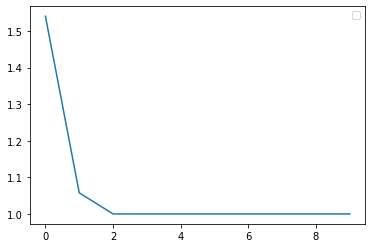

In [ ]:
distance = distances.SNRDistance()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="semihard") # molt important
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

model_semihard = EmbeddingNet().to(device)
optimizer = optim.Adam(model_semihard.parameters(), lr=0.01)
loss_func = losses.SignalToNoiseRatioContrastiveLoss(distance = distance)

num_epochs = 10
loss_evolution_semihard = []

for epoch in range(1, num_epochs + 1):
    loss = train(model_semihard, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution_semihard.append(loss)
    test(train_dataset, test_dataset, model_semihard, accuracy_calculator)

plt.plot(loss_evolution_semihard)
plt.legend()
plt.show()

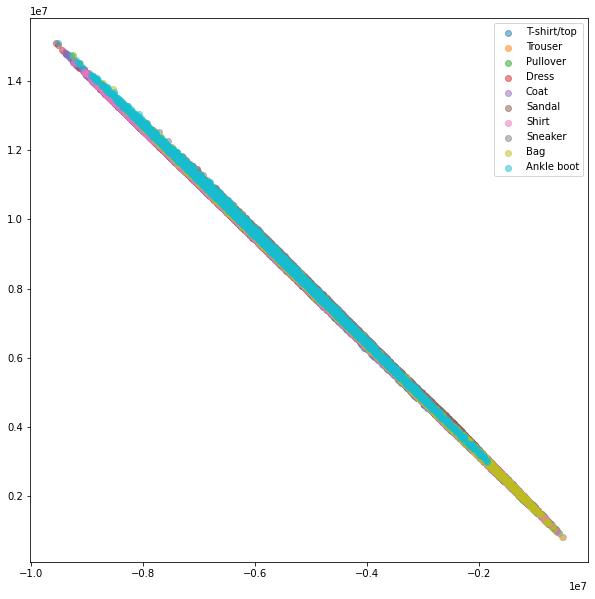

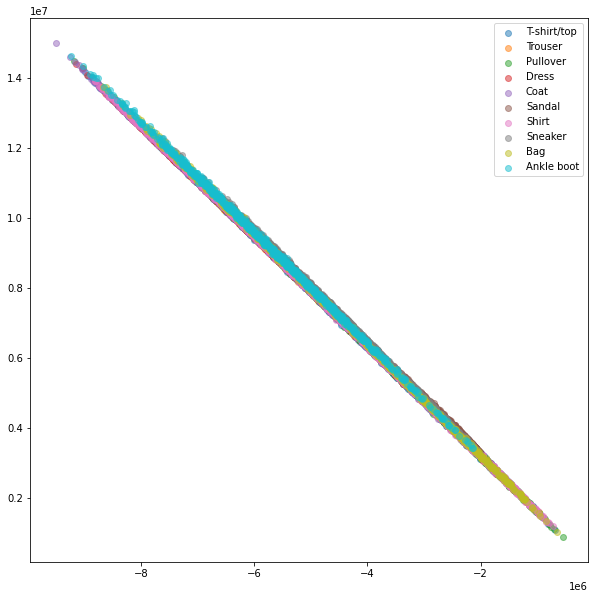

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model_semihard)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model_semihard)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Better embeddings

<br>
<span style="color:blue">

**Exercise 3**: Train a new (preferably more powerful) network with a 128-dimensional embedding, visualize the embedding using T-SNE. The T-SNE library is installed in the cell below check the [github repo](https://github.com/DmitryUlyanov/Multicore-TSNE) for info on how to use it. Report accuracies for both networks (the one with 2-dimensional embeddings and this one) and compare the visualizations of both embeddings.

Explanation of T-SNE [here](https://distill.pub/2016/misread-tsne/)

**Important T-SNE is rather slow so dont visualize the embeddings for every sample. Randomly select a few**

</span>

> En lloc de crear embedding de dos dimensions, creem embedding on la dimensio sigui 128 i per poder visualitzar-la apliquem el TSNE.

In [ ]:
!pip3 install MulticoreTSNE

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 128)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

Epoch 1 Iteration 0: Loss = 0.9679687023162842, Number of mined triplets = 1184230
Epoch 1 Iteration 20: Loss = 0.9136397242546082, Number of mined triplets = 131952
Epoch 1 Iteration 40: Loss = 0.9177862405776978, Number of mined triplets = 150567
Epoch 1 Iteration 60: Loss = 0.9179208874702454, Number of mined triplets = 102586
Epoch 1 Iteration 80: Loss = 0.9010031223297119, Number of mined triplets = 92099
Epoch 1 Iteration 100: Loss = 0.9024108052253723, Number of mined triplets = 86211
Epoch 1 Iteration 120: Loss = 0.8983289003372192, Number of mined triplets = 83454
Epoch 1 Iteration 140: Loss = 0.9047776460647583, Number of mined triplets = 73707
Epoch 1 Iteration 160: Loss = 0.9004445672035217, Number of mined triplets = 62726
Epoch 1 Iteration 180: Loss = 0.9031220078468323, Number of mined triplets = 66162
Epoch 1 Iteration 200: Loss = 0.8990657925605774, Number of mined triplets = 60460
Epoch 1 Iteration 220: Loss = 0.8984704613685608, Number of mined triplets = 61398


100%|██████████| 313/313 [00:03<00:00, 85.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8104
Epoch 2 Iteration 0: Loss = 0.9007090926170349, Number of mined triplets = 56378
Epoch 2 Iteration 20: Loss = 0.8924410343170166, Number of mined triplets = 45974
Epoch 2 Iteration 40: Loss = 0.8985565900802612, Number of mined triplets = 61461
Epoch 2 Iteration 60: Loss = 0.8948241472244263, Number of mined triplets = 56316
Epoch 2 Iteration 80: Loss = 0.894497811794281, Number of mined triplets = 50131
Epoch 2 Iteration 100: Loss = 0.8934482932090759, Number of mined triplets = 30888
Epoch 2 Iteration 120: Loss = 0.8962661027908325, Number of mined triplets = 37087
Epoch 2 Iteration 140: Loss = 0.8975849151611328, Number of mined triplets = 52732
Epoch 2 Iteration 160: Loss = 0.8953299522399902, Number of mined triplets = 32246
Epoch 2 Iteration 180: Loss = 0.893869161605835, Number of mined triplets = 48093
Epoch 2 Iteration 200: Loss = 0.8998135328292847, Number of mined triplets = 48220
Epoch 2 Iteration 220: Loss = 0.893

100%|██████████| 313/313 [00:03<00:00, 82.70it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8550000000000001
Epoch 3 Iteration 0: Loss = 0.8968508243560791, Number of mined triplets = 30951
Epoch 3 Iteration 20: Loss = 0.8928728103637695, Number of mined triplets = 42704
Epoch 3 Iteration 40: Loss = 0.8936836123466492, Number of mined triplets = 34807
Epoch 3 Iteration 60: Loss = 0.8958636522293091, Number of mined triplets = 30547
Epoch 3 Iteration 80: Loss = 0.8935689926147461, Number of mined triplets = 34681
Epoch 3 Iteration 100: Loss = 0.8969637155532837, Number of mined triplets = 50508
Epoch 3 Iteration 120: Loss = 0.9025286436080933, Number of mined triplets = 34130
Epoch 3 Iteration 140: Loss = 0.8980125188827515, Number of mined triplets = 45419
Epoch 3 Iteration 160: Loss = 0.8986603617668152, Number of mined triplets = 36403
Epoch 3 Iteration 180: Loss = 0.8962835669517517, Number of mined triplets = 36396
Epoch 3 Iteration 200: Loss = 0.8949011564254761, Number of mined triplets = 43431
Epoch 3 Iteration 220

100%|██████████| 313/313 [00:03<00:00, 81.71it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8666
Epoch 4 Iteration 0: Loss = 0.8892925381660461, Number of mined triplets = 27288
Epoch 4 Iteration 20: Loss = 0.8955559134483337, Number of mined triplets = 31981
Epoch 4 Iteration 40: Loss = 0.8939913511276245, Number of mined triplets = 28737
Epoch 4 Iteration 60: Loss = 0.896874189376831, Number of mined triplets = 30603
Epoch 4 Iteration 80: Loss = 0.8931529521942139, Number of mined triplets = 29177
Epoch 4 Iteration 100: Loss = 0.8912215232849121, Number of mined triplets = 47032
Epoch 4 Iteration 120: Loss = 0.8892524242401123, Number of mined triplets = 23040
Epoch 4 Iteration 140: Loss = 0.8963612914085388, Number of mined triplets = 19840
Epoch 4 Iteration 160: Loss = 0.8918460011482239, Number of mined triplets = 38211
Epoch 4 Iteration 180: Loss = 0.8994579315185547, Number of mined triplets = 25536
Epoch 4 Iteration 200: Loss = 0.8943900465965271, Number of mined triplets = 36287
Epoch 4 Iteration 220: Loss = 0.89

100%|██████████| 313/313 [00:06<00:00, 48.77it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8772000000000001
Epoch 5 Iteration 0: Loss = 0.8960475325584412, Number of mined triplets = 32760
Epoch 5 Iteration 20: Loss = 0.8955980539321899, Number of mined triplets = 30581
Epoch 5 Iteration 40: Loss = 0.8919576406478882, Number of mined triplets = 28251
Epoch 5 Iteration 60: Loss = 0.8932653069496155, Number of mined triplets = 50129
Epoch 5 Iteration 80: Loss = 0.8930293321609497, Number of mined triplets = 34982
Epoch 5 Iteration 100: Loss = 0.8913850784301758, Number of mined triplets = 33090
Epoch 5 Iteration 120: Loss = 0.8983507752418518, Number of mined triplets = 25396
Epoch 5 Iteration 140: Loss = 0.8916841149330139, Number of mined triplets = 39613
Epoch 5 Iteration 160: Loss = 0.8943930268287659, Number of mined triplets = 29616
Epoch 5 Iteration 180: Loss = 0.89372318983078, Number of mined triplets = 23220
Epoch 5 Iteration 200: Loss = 0.8923248052597046, Number of mined triplets = 26012
Epoch 5 Iteration 220: 

100%|██████████| 313/313 [00:03<00:00, 81.29it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.882
Epoch 6 Iteration 0: Loss = 0.8921257257461548, Number of mined triplets = 30985
Epoch 6 Iteration 20: Loss = 0.8939200639724731, Number of mined triplets = 19791
Epoch 6 Iteration 40: Loss = 0.9001314640045166, Number of mined triplets = 17730
Epoch 6 Iteration 60: Loss = 0.8963322639465332, Number of mined triplets = 30785
Epoch 6 Iteration 80: Loss = 0.8986315131187439, Number of mined triplets = 19711
Epoch 6 Iteration 100: Loss = 0.8947872519493103, Number of mined triplets = 20097
Epoch 6 Iteration 120: Loss = 0.8949141502380371, Number of mined triplets = 23352
Epoch 6 Iteration 140: Loss = 0.8955177068710327, Number of mined triplets = 29087
Epoch 6 Iteration 160: Loss = 0.8958054184913635, Number of mined triplets = 24727
Epoch 6 Iteration 180: Loss = 0.8912055492401123, Number of mined triplets = 20650
Epoch 6 Iteration 200: Loss = 0.8885077834129333, Number of mined triplets = 17040
Epoch 6 Iteration 220: Loss = 0.89

100%|██████████| 313/313 [00:03<00:00, 80.83it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8906000000000001
Epoch 7 Iteration 0: Loss = 0.8995537757873535, Number of mined triplets = 25875
Epoch 7 Iteration 20: Loss = 0.8917304277420044, Number of mined triplets = 31100
Epoch 7 Iteration 40: Loss = 0.8932361006736755, Number of mined triplets = 19657
Epoch 7 Iteration 60: Loss = 0.8962778449058533, Number of mined triplets = 21615
Epoch 7 Iteration 80: Loss = 0.8885588645935059, Number of mined triplets = 13850
Epoch 7 Iteration 100: Loss = 0.8931376338005066, Number of mined triplets = 20681
Epoch 7 Iteration 120: Loss = 0.8891488313674927, Number of mined triplets = 14014
Epoch 7 Iteration 140: Loss = 0.895463228225708, Number of mined triplets = 29449
Epoch 7 Iteration 160: Loss = 0.8935869932174683, Number of mined triplets = 18305
Epoch 7 Iteration 180: Loss = 0.892501175403595, Number of mined triplets = 20504
Epoch 7 Iteration 200: Loss = 0.896735429763794, Number of mined triplets = 19831
Epoch 7 Iteration 220: L

100%|██████████| 313/313 [00:03<00:00, 82.59it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8911
Epoch 8 Iteration 0: Loss = 0.8938366174697876, Number of mined triplets = 23302
Epoch 8 Iteration 20: Loss = 0.8941635489463806, Number of mined triplets = 24108
Epoch 8 Iteration 40: Loss = 0.8878394961357117, Number of mined triplets = 19843
Epoch 8 Iteration 60: Loss = 0.8961191773414612, Number of mined triplets = 29697
Epoch 8 Iteration 80: Loss = 0.8884884715080261, Number of mined triplets = 28346
Epoch 8 Iteration 100: Loss = 0.8926344513893127, Number of mined triplets = 16764
Epoch 8 Iteration 120: Loss = 0.893786609172821, Number of mined triplets = 18325
Epoch 8 Iteration 140: Loss = 0.8908923268318176, Number of mined triplets = 29546
Epoch 8 Iteration 160: Loss = 0.8914358615875244, Number of mined triplets = 13104
Epoch 8 Iteration 180: Loss = 0.8938773274421692, Number of mined triplets = 15166
Epoch 8 Iteration 200: Loss = 0.8947669863700867, Number of mined triplets = 9052
Epoch 8 Iteration 220: Loss = 0.890

100%|██████████| 313/313 [00:03<00:00, 81.61it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8965000000000001
Epoch 9 Iteration 0: Loss = 0.8932909369468689, Number of mined triplets = 22312
Epoch 9 Iteration 20: Loss = 0.8887426853179932, Number of mined triplets = 17261
Epoch 9 Iteration 40: Loss = 0.885981559753418, Number of mined triplets = 15436
Epoch 9 Iteration 60: Loss = 0.8922065496444702, Number of mined triplets = 17772
Epoch 9 Iteration 80: Loss = 0.8985342979431152, Number of mined triplets = 18609
Epoch 9 Iteration 100: Loss = 0.8954011797904968, Number of mined triplets = 21910
Epoch 9 Iteration 120: Loss = 0.8888176083564758, Number of mined triplets = 14211
Epoch 9 Iteration 140: Loss = 0.888604462146759, Number of mined triplets = 16691
Epoch 9 Iteration 160: Loss = 0.894935131072998, Number of mined triplets = 23327
Epoch 9 Iteration 180: Loss = 0.8924664258956909, Number of mined triplets = 25161
Epoch 9 Iteration 200: Loss = 0.8863202333450317, Number of mined triplets = 26140
Epoch 9 Iteration 220: L

100%|██████████| 313/313 [00:04<00:00, 67.05it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8943000000000001
Epoch 10 Iteration 0: Loss = 0.8906137347221375, Number of mined triplets = 12208
Epoch 10 Iteration 20: Loss = 0.8915833830833435, Number of mined triplets = 16035
Epoch 10 Iteration 40: Loss = 0.8868526220321655, Number of mined triplets = 23923
Epoch 10 Iteration 60: Loss = 0.8925862312316895, Number of mined triplets = 30912
Epoch 10 Iteration 80: Loss = 0.8906108736991882, Number of mined triplets = 20533
Epoch 10 Iteration 100: Loss = 0.8911460041999817, Number of mined triplets = 23911
Epoch 10 Iteration 120: Loss = 0.8918516039848328, Number of mined triplets = 27277
Epoch 10 Iteration 140: Loss = 0.9063109755516052, Number of mined triplets = 25839
Epoch 10 Iteration 160: Loss = 0.896304726600647, Number of mined triplets = 14705
Epoch 10 Iteration 180: Loss = 0.8929523825645447, Number of mined triplets = 10858
Epoch 10 Iteration 200: Loss = 0.8872882127761841, Number of mined triplets = 17340
Epoch 10 It

100%|██████████| 313/313 [00:03<00:00, 82.10it/s]


Computing accuracy


No handles with labels found to put in legend.


Test set accuracy (Precision@1) = 0.898


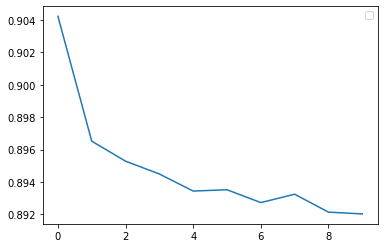

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, n_jobs=2)

distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="semihard") # molt important
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

model = EmbeddingNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1., distance = distance)

num_epochs = 10
loss_evolution = []

for epoch in range(1, num_epochs + 1):
    loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution.append(loss)
    test(train_dataset, test_dataset, model, accuracy_calculator)

plt.plot(loss_evolution)
plt.legend()
plt.show()

In [ ]:
train_embeddings_baseline_128, train_labels_baseline_128 = extract_embeddings(train_loader, model, 128)
train_embeddings_tsne = tsne.fit_transform(train_embeddings_baseline_128)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.006s...
[t-SNE] Computed neighbors for 60000 samples in 120.861s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

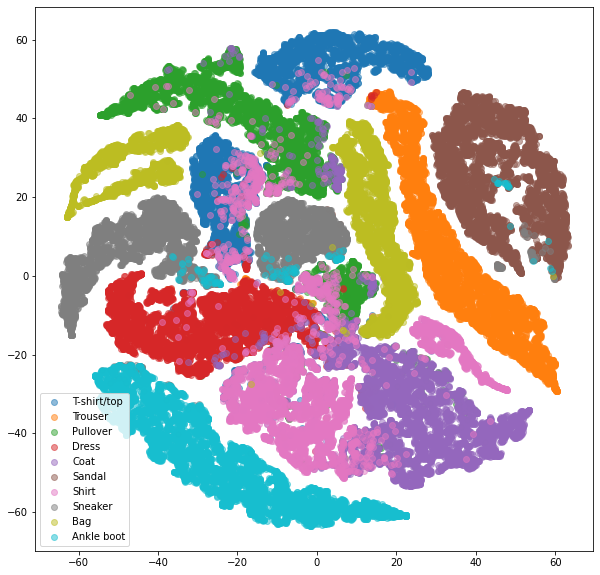

In [ ]:
plot_embeddings(train_embeddings_tsne, train_labels_baseline_128)

Per aquest nou entrenament hem utilitzat un embedding de 128 dimensions, en el qual es pot emmagatzemar molta més informació que a l'anterior embedding de 2. Ara el model és capaç de distingir certs matisos o característiques de manera més abstracta (associant conceptes d'intersecció entre classes).

La representació visual que es mostra a la darrera execució és una adaptació en 2d dels embeddings creats en 128d, és per aquest motiu que no s'aconsegueix entendre amb tanta facilitat com anteriorment les separacions intra-classes del dataset. Podem veure de forma superficial els diferents grups que el model ha associat automàticament i, igual que amb els embeddings en 2d, encara li costa decidir la separació entre les classes que contenen parts de dalt (classes molt semblants, per exemple camisa i camiseta).

Com a conclusió general, al meu entendre aquest nou model amb un embedding més específic obtindria millors resultats en qualsevol tasca, com ara classificació.